In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from sklearn.preprocessing import StandardScaler
import missingno as msno

# Importing Dataset 

In [2]:
df  = pd.read_csv("data/kaggle_1.csv")
df.sample(20)

Unnamed: 0.1  Unnamed: 0  \
8426          8426      8426.0   
915            915       915.0   
6887          6887      6887.0   
2755          2755      2755.0   
5450          5450      5450.0   
2514          2514      2514.0   
6272          6272      6272.0   
9432          9432         NaN   
2859          2859      2859.0   
3206          3206      3206.0   
1188          1188      1188.0   
8189          8189      8189.0   
7977          7977      7977.0   
4786          4786      4786.0   
7065          7065      7065.0   
3447          3447      3447.0   
3892          3892      3892.0   
6780          6780      6780.0   
2266          2266      2266.0   
9222          9222      9222.0   

                                                   text  \
8426                                                NaN   
915   <BOS> In their sweet flutelanguage there are n...   
6887  <BOS> You see, there isnt much time left, cont...   
2755  <BOS> This instant the door was broken open, a...   
5450  \n\nGentlemen , start your hair dryers . In an...   
2514  <BOS> I think it is time for a story of less m...   
6272  <BOS> But no one need ever know. Nothing could...   
9432  Dramatis Personae .\nMERLIN , Mr. BENSLEY .\nC...   
2859  <BOS> A few hours passed by in quietness, and ...   
3206  <BOS> For in those vessels, the fishingtime at...   
1188  <BOS> Indeed, the discussions to which it gave...   
8189                                                NaN   
7977                                                NaN   
4786  <BOS> Ormonde and Lady Alice got through the d...   
7065  <BOS> Im not trying to make a home here. Im af...   
3447  <BOS> The murmur went on for some moments, bro...   
3892  <BOS> Well, the hearty words are yours. Direct...   
6780  <BOS> The clash and the conflict of racesthe a...   
2266  <BOS> I kissed him and clung to him, and he no...   
9222                                                NaN   

                                               category    date  \
8426                                                NaN     NaN   
915                      Love stories; Wales -- Fiction  1870.0   
6887  Airships -- Juvenile fiction; Aeronautics -- J...  1909.0   
2755  Women -- Fiction; Frontier and pioneer life --...  1861.0   
5450                                                mag  2004.0   
2514  Australia -- Juvenile fiction; Voyages and tra...  1896.0   
6272  Young women -- Fiction; Love stories; Canada -...  1910.0   
9432                                              Drama    1766   
2859  Science fiction; Western stories; American fic...  1892.0   
3206  Whaling -- Fiction; Sea stories; Sperm whale h...  1898.0   
1188  Country life -- England -- Fiction; England --...  1848.0   
8189                                                NaN     NaN   
7977                                                NaN     NaN   
4786  Inheritance and succession -- Fiction; England...  1889.0   
7065  Lumber trade -- Fiction; Northwest, Pacific --...  1916.0   
3447  Girls -- Conduct of life -- Juvenile fiction; ...  1898.0   
3892  Historical fiction; Jesus Christ -- Fiction; C...  1887.0   
6780                                  Canada -- Fiction  1922.0   
2266   Fantasy fiction; Quests (Expeditions) -- Fiction  1892.0   
9222                                                NaN     NaN   

                                                  title  \
8426                                                NaN   
915                       Red as a Rose is She: A Novel   
6887  The Air Ship Boys : Or, the Quest of the Aztec...   
2755  Sybil Chase; or, The Valley Ranche: A Tale of ...   
5450                                         365050.txt   
2514  The Land of the Kangaroo\nAdventures of Two Yo...   
6272  A Countess from Canada: A Story of Life in the...   
9432                                              Cymon   
2859                    Frank Reade and His Steam Horse   
3206  The Cruise of the "Cachalot" Round the World A.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9729 entries, 0 to 9728
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  9729 non-null   int64  
 1   Unnamed: 0    9396 non-null   float64
 2   text          8295 non-null   object 
 3   category      8295 non-null   object 
 4   date          8295 non-null   object 
 5   title         8295 non-null   object 
 6   author        8281 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 532.2+ KB


# Checking for missing values

<Axes: >

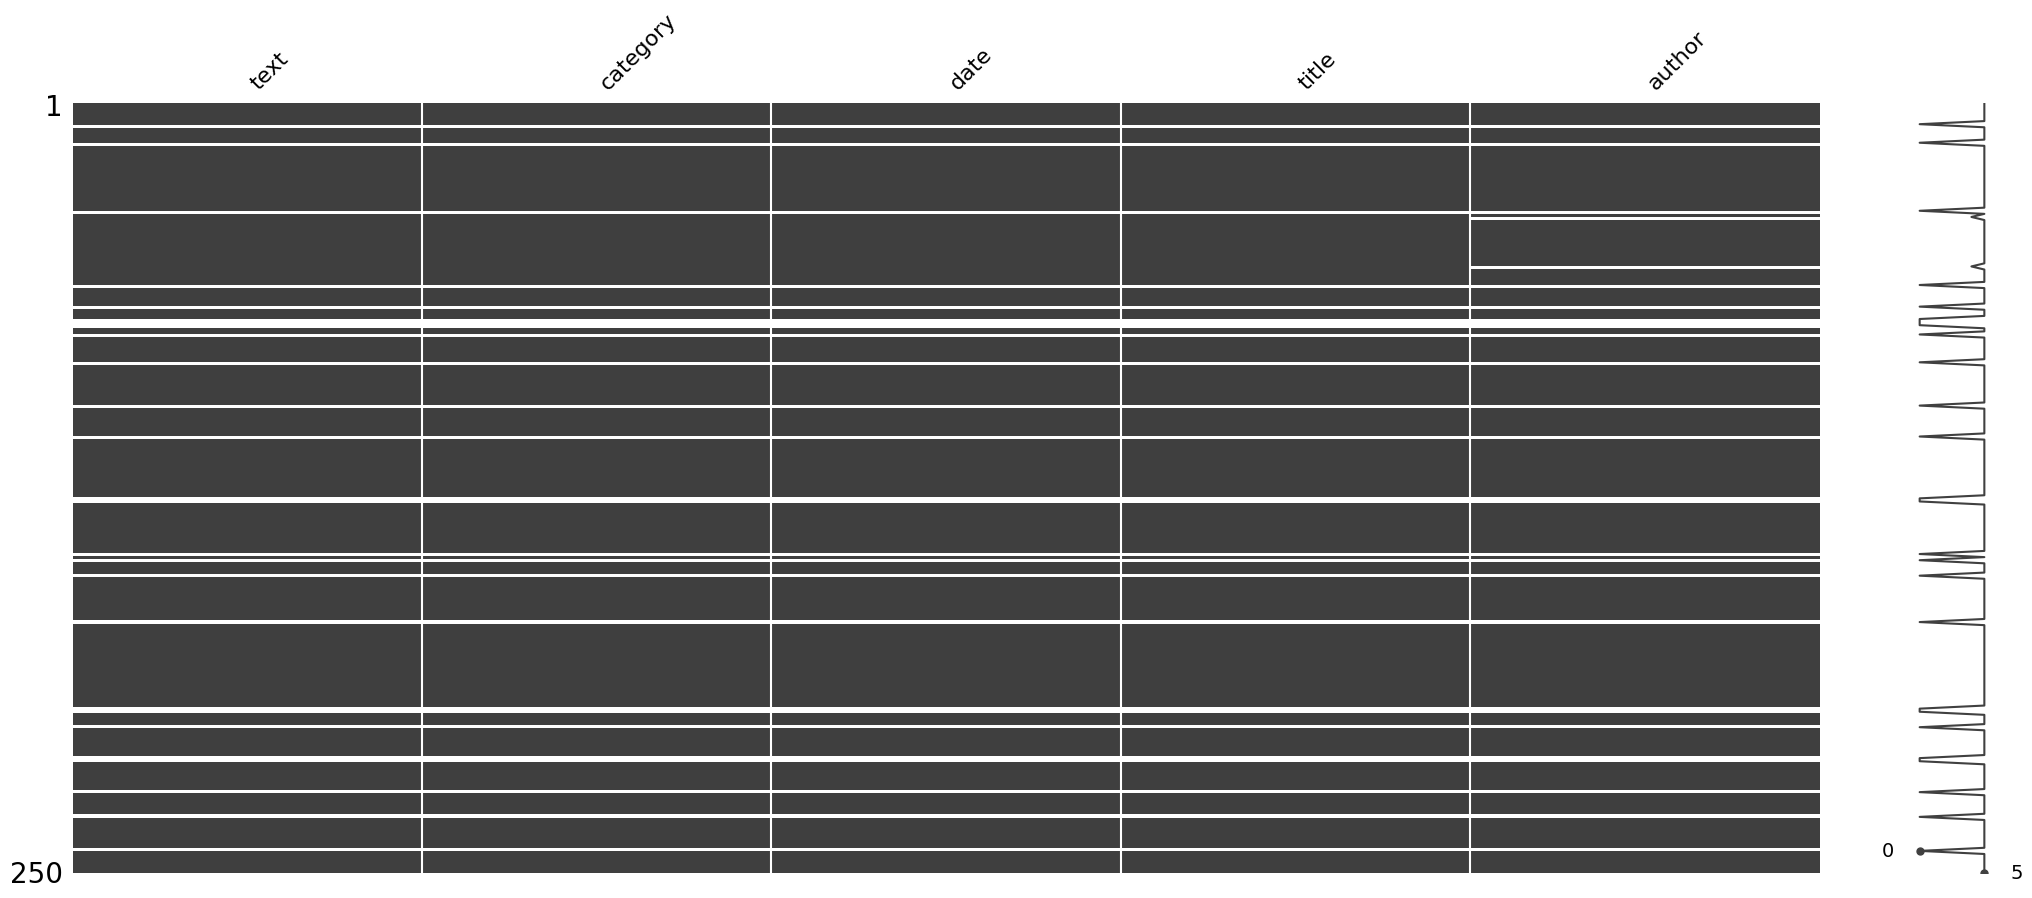

In [4]:
df.drop(["Unnamed: 0.1","Unnamed: 0"],axis=1,inplace=True)
msno.matrix(df.sample(250))

In [5]:
df.dropna(inplace=True)

# Removing all non-alphanumeric characters followed by other errors in the text

In [6]:
df['text'] = df['text'].replace('ſ', 's', regex=True)
df['text'] = df['text'].replace('<BOS>', ' ', regex=True)
df['text'] = df['text'].replace("[^a-zA-Z0-9 ']", ' ', regex=True)
df['text'] = df['text'].replace("@", ' ', regex=True)
df['text'] = df['text'].replace("EOS", ' ', regex=True)
df['text'] = df['text'].replace("haue", ' ', regex=True)
df['text'] = df['text'].replace("vnto", ' ', regex=True)

# Splitting the years into decades and restricting them to the range from 1500 to 1920

In [7]:
df['date'] = pd.to_numeric(df['date'], errors='coerce', downcast='integer')
df['decade'] = (df['date'] // 10) * 10

In [8]:
df = df[(df["decade"] >= 1500) & (df["decade"] < 1920)]


In [9]:
# Splitting the text into multiple sections for books that have a lot of data

def split_rows_based_on_word_count(df, column_name, word_count_threshold):
    new_rows = []

    for index, row in df.iterrows():
        text = row[column_name]
        words = text.split()
        
        if len(words) > word_count_threshold:
            # Split the text into multiple rows
            split_texts = [words[i:i+word_count_threshold] for i in range(0, len(words), word_count_threshold)]
            
            for split_text in split_texts:
                new_row = row.copy()
                new_row[column_name] = ' '.join(split_text)
                new_rows.append(new_row)
        else:
            # Keep the row as it is
            new_rows.append(row)

    return pd.DataFrame(new_rows, columns=df.columns)


word_count_threshold = 750  # Set your desired word count threshold
df = split_rows_based_on_word_count(df, 'text', word_count_threshold)

# Now, 'new_dataframe' contains the rows split based on the word count threshold


In [10]:
threshold = 800
df = df.groupby('decade').head(threshold)
print(df)


                                                   text  \
0     TabulaChronicles of England 1502Approx 1361 KB...   
0     text with mnemonic sdata character entities di...   
0     Brytayneleafc v viIoathan kynge of IewesAmaria...   
0     quevult saluus esseMercus popeIulius popeConst...   
0     the fourth popeInnocencius the fourth popeleaf...   
...                                                 ...   
9646  appealed to me the kind of nature romance whic...   
9646  long delayed Yet she lingered with us six week...   
9646  exemplified in the very lively interest which ...   
9646  not what awakened in my soul The two retreats ...   
9646  into dire distress before very long we learned...   

                   category    date           title         author  decade  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-

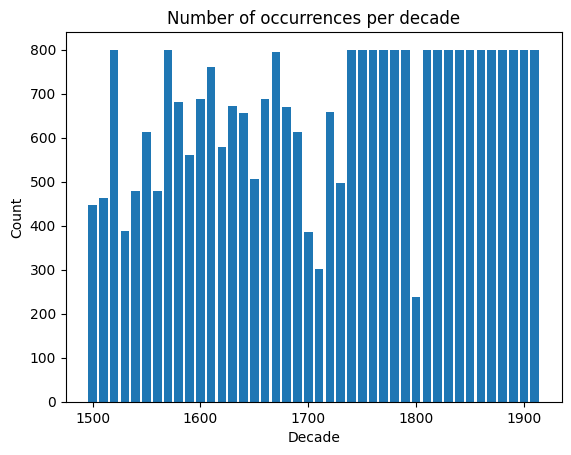

In [11]:
# Visualizing according to number of rows per decade to better understand the data distribution
decade_counts = df['decade'].value_counts().sort_index()

# Create a bar graph
plt.bar(decade_counts.index, decade_counts.values, width=8)  # Adjust the width as needed

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Number of occurrences per decade')

# Display the graph
plt.show()


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28012 entries, 0 to 9646
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      28012 non-null  object 
 1   category  28012 non-null  object 
 2   date      28012 non-null  float64
 3   title     28012 non-null  object 
 4   author    28012 non-null  object 
 5   decade    28012 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.5+ MB


In [13]:
# Randomly selecting around 27.5K rows from the dataset. This threshold was set due to hardware constraints

df = df.sample(2000)

# SVR - TfIdf 

Training RMSE: 106.74075945978632
Testing RMSE: 104.79480952276408
Training MAE: 91.63725933145025
Testing MAE: 90.13192945062836
Training R-squared: 0.22924711498930095
Testing R-squared: 0.22722797286625063


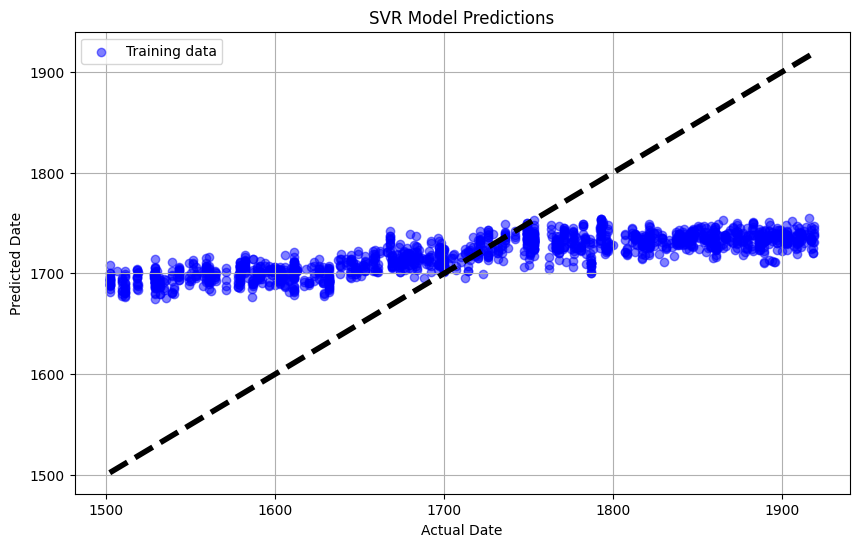

In [14]:

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=4000)
train_text_features = tfidf_vectorizer.fit_transform(train_data)
test_text_features = tfidf_vectorizer.transform(test_data)

# Initialize and train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

# Feature Importance Plot - Not applicable for SVR

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, color='blue', label='Training data', alpha=0.5)
#plt.scatter(test_labels, test_predictions, color='red', label='Testing data', alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('SVR Model Predictions')
plt.xlabel('Actual Date')
plt.ylabel('Predicted Date')
plt.grid(True)
plt.legend()
plt.show()


# SVR - Word2Vec

Training RMSE: 120.76982754499802
Testing RMSE: 104.79480952276408
Training MAE: 103.87526598195979
Testing MAE: 102.37078356548115
Training R-squared: 0.013331020554620654
Testing R-squared: 0.0003124692422872277


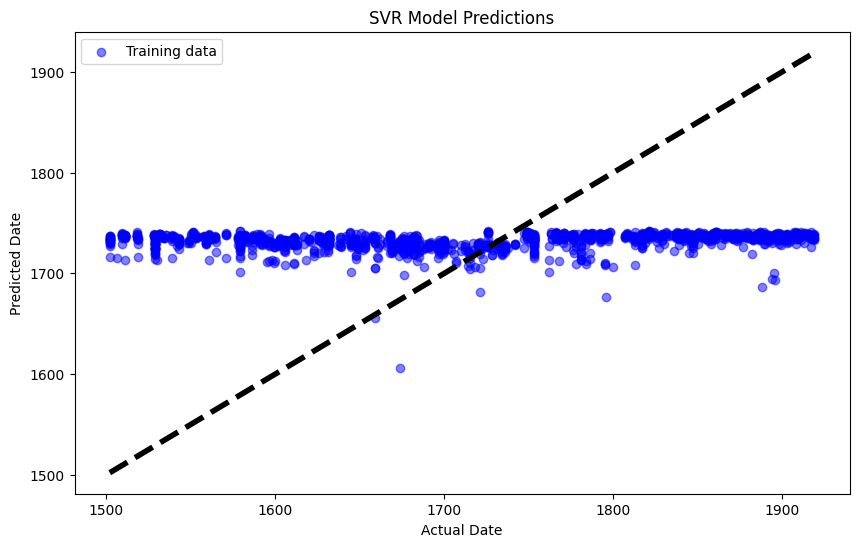

In [15]:


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to Word2Vec features
# Assuming 'text' column contains lists of tokenized words
word2vec_model = Word2Vec(sentences=train_data, vector_size=400, window=5, min_count=1, workers=16)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=20)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X  if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse_w2v = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse_w2v = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)

print("Training RMSE:", train_rmse_w2v)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

# Feature Importance Plot - Not applicable for SVR

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, color='blue', label='Training data', alpha=0.5)
#plt.scatter(test_labels, test_predictions, color='red', label='Testing data', alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('SVR Model Predictions')
plt.xlabel('Actual Date')
plt.ylabel('Predicted Date')
plt.legend()
plt.show()

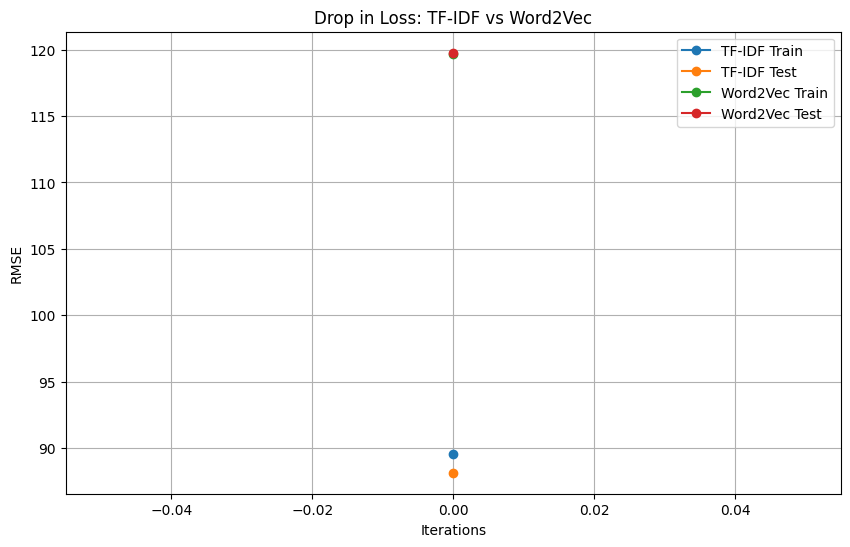

In [16]:
import matplotlib.pyplot as plt

# RMSE values for TF-IDF
tfidf_train_rmse = [train_rmse]
tfidf_test_rmse = [test_rmse]

# RMSE values for Word2Vec
w2v_train_rmse = [train_rmse_w2v]
w2v_test_rmse = [test_rmse_w2v]

# Plotting the drop in loss
plt.figure(figsize=(10, 6))
plt.plot(tfidf_train_rmse, label='TF-IDF Train', marker='o')
plt.plot(tfidf_test_rmse, label='TF-IDF Test', marker='o')
plt.plot(w2v_train_rmse, label='Word2Vec Train', marker='o')
plt.plot(w2v_test_rmse, label='Word2Vec Test', marker='o')
plt.title('Drop in Loss: TF-IDF vs Word2Vec')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


# Gradient Boosting - TfIdf

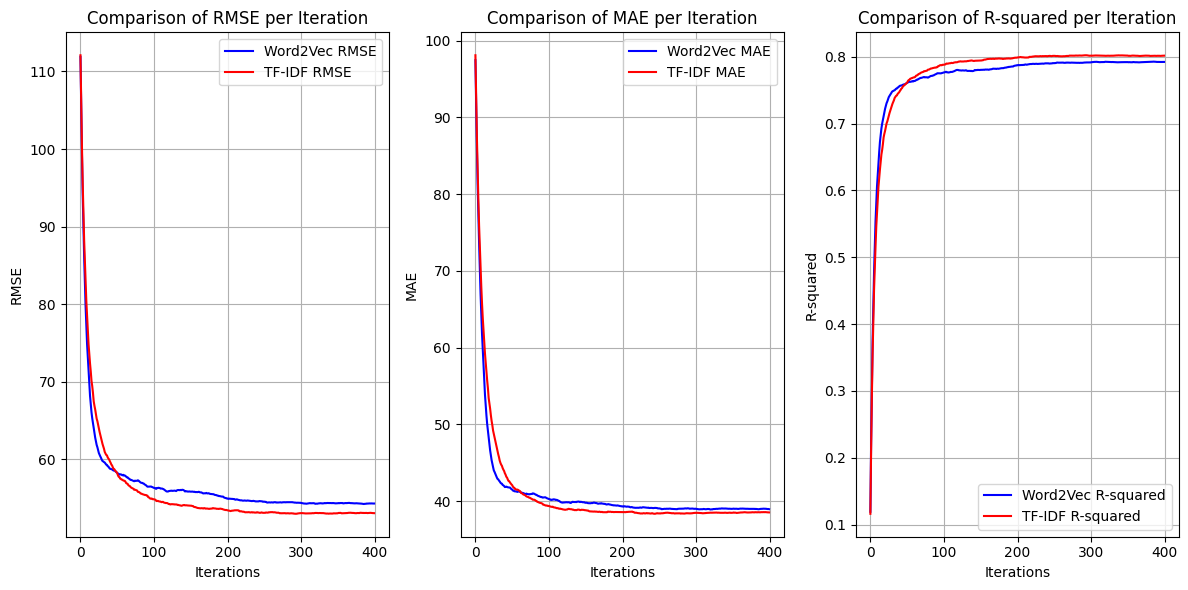

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# Assuming df is your DataFrame

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=400)
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=400, window=5, min_count=1, workers=16)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

train_text_features_wv = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features_wv = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the Gradient Boosting model for TF-IDF
gb_model_tfidf = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)
gb_model_tfidf.fit(train_text_features_tfidf, train_labels)

# Initialize and train the Gradient Boosting model for Word2Vec
gb_model_wv = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)
gb_model_wv.fit(train_text_features_wv, train_labels)

# Track RMSE, MAE, and R-squared over iterations for test data for TF-IDF
test_rmse_scores_tfidf = []
test_mae_scores_tfidf = []
test_r2_scores_tfidf = []
for i, y_pred in enumerate(gb_model_tfidf.staged_predict(test_text_features_tfidf)):
    test_rmse_scores_tfidf.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_tfidf.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_tfidf.append(r2_score(test_labels, y_pred))

# Track RMSE, MAE, and R-squared over iterations for test data for Word2Vec
test_rmse_scores_wv = []
test_mae_scores_wv = []
test_r2_scores_wv = []
for i, y_pred in enumerate(gb_model_wv.staged_predict(test_text_features_wv)):
    test_rmse_scores_wv.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_wv.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_wv.append(r2_score(test_labels, y_pred))

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(test_rmse_scores_wv, label='Word2Vec RMSE', color='blue')
plt.plot(test_rmse_scores_tfidf, label='TF-IDF RMSE', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_mae_scores_wv, label='Word2Vec MAE', color='blue')
plt.plot(test_mae_scores_tfidf, label='TF-IDF MAE', color='red')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_r2_scores_wv, label='Word2Vec R-squared', color='blue')
plt.plot(test_r2_scores_tfidf, label='TF-IDF R-squared', color='red')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


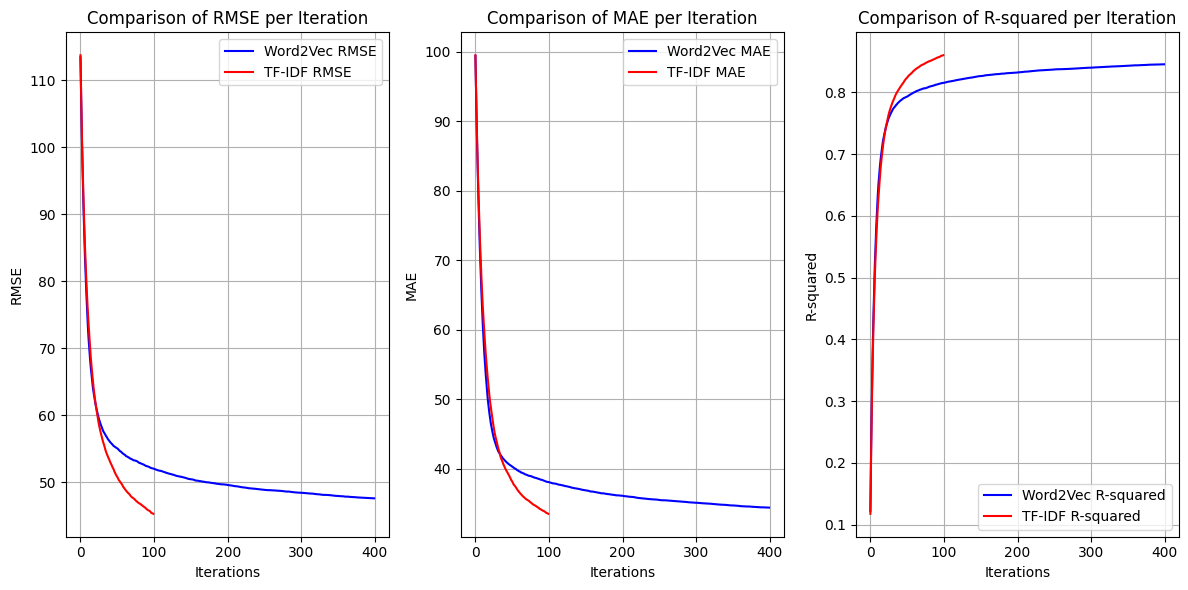

In [38]:

train_text_features_wv = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features_wv = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the Gradient Boosting model for TF-IDF
gb_model_tfidf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model_tfidf.fit(train_text_features_tfidf, train_labels)

# Initialize and train the Gradient Boosting model for Word2Vec
gb_model_wv = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, random_state=42)
gb_model_wv.fit(train_text_features_wv, train_labels)

# Track RMSE, MAE, and R-squared over iterations for test data for TF-IDF
test_rmse_scores_tfidf = []
test_mae_scores_tfidf = []
test_r2_scores_tfidf = []
for i, y_pred in enumerate(gb_model_tfidf.staged_predict(test_text_features_tfidf)):
    test_rmse_scores_tfidf.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_tfidf.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_tfidf.append(r2_score(test_labels, y_pred))

# Track RMSE, MAE, and R-squared over iterations for test data for Word2Vec
test_rmse_scores_wv = []
test_mae_scores_wv = []
test_r2_scores_wv = []
for i, y_pred in enumerate(gb_model_wv.staged_predict(test_text_features_wv)):
    test_rmse_scores_wv.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_wv.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_wv.append(r2_score(test_labels, y_pred))

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(test_rmse_scores_wv, label='Word2Vec RMSE', color='blue')
plt.plot(test_rmse_scores_tfidf, label='TF-IDF RMSE', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_mae_scores_wv, label='Word2Vec MAE', color='blue')
plt.plot(test_mae_scores_tfidf, label='TF-IDF MAE', color='red')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_r2_scores_wv, label='Word2Vec R-squared', color='blue')
plt.plot(test_r2_scores_tfidf, label='TF-IDF R-squared', color='red')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:
test_r2_scores_wv

[0.1223003414672903,
 0.22203259629075944,
 0.3051429263442955,
 0.37291115508430306,
 0.42957493802968205,
 0.47625406532696046,
 0.5185178823606624,
 0.5520923887368889,
 0.5826015490185552,
 0.6091328141100281,
 0.6322359504385847,
 0.6514684439542108,
 0.6667377059965854,
 0.6803897557175941,
 0.6923412338596975,
 0.7022252755718161,
 0.7114588445365149,
 0.720293807956119,
 0.7265234684985045,
 0.7321675817222328,
 0.7378934930760981,
 0.7431224876406515,
 0.7471957521397533,
 0.7510800811664562,
 0.7546906720619084,
 0.7586884337574945,
 0.7610326183993297,
 0.7639952443713988,
 0.7664603433069517,
 0.7687108537143899,
 0.7711209160067736,
 0.7733756881150917,
 0.7747923097139897,
 0.7759909421863889,
 0.7777283372492919,
 0.7793663729109191,
 0.7804473661093965,
 0.782184849145714,
 0.7832422647188615,
 0.7843616830986667,
 0.7856118961365682,
 0.7865609403322446,
 0.7873936876832506,
 0.7883241021931056,
 0.7891985511684576,
 0.790258264000969,
 0.7908397155414346,
 0.791434631

In [43]:

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 100)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 100)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(train_text_features, train_labels)

# Track RMSE loss over iterations for test data
test_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(test_text_features)):
    test_score[i] = sqrt(mean_squared_error(test_labels, y_pred))

# Track RMSE loss over iterations for training data
train_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(train_text_features)):
    train_score[i] = sqrt(mean_squared_error(train_labels, y_pred))

# Generate predictions
predictions = gb_model.predict(test_text_features)

# Plotting Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.8)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

# Xgboost Tfidf and Word2vec

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:94.97071	validation_0-mae:80.47849
[1]	validation_0-rmse:77.26727	validation_0-mae:64.74284
[2]	validation_0-rmse:67.07071	validation_0-mae:55.38817
[3]	validation_0-rmse:61.41403	validation_0-mae:50.03592
[4]	validation_0-rmse:58.45404	validation_0-mae:46.59509
[5]	validation_0-rmse:56.51191	validation_0-mae:44.59872
[6]	validation_0-rmse:55.13812	validation_0-mae:43.21160
[7]	validation_0-rmse:54.17120	validation_0-mae:42.02930
[8]	validation_0-rmse:53.37623	validation_0-mae:40.87629
[9]	validation_0-rmse:52.93391	validation_0-mae:40.32975
[10]	validation_0-rmse:52.65618	validation_0-mae:40.03942
[11]	validation_0-rmse:52.75766	validation_0-mae:40.04078
[12]	validation_0-rmse:52.49907	validation_0-mae:39.75231
[13]	validation_0-rmse:52.45257	validation_0-mae:39.51954
[14]	validation_0-rmse:52.46854	validation_0-mae:39.53274
[15]	validation_0-rmse:52.83482	validation_0-mae:39.77785
[16]	validation_0-rmse:52.83398	validation_0-mae:39.82053
[17]	validation_0-rmse:5

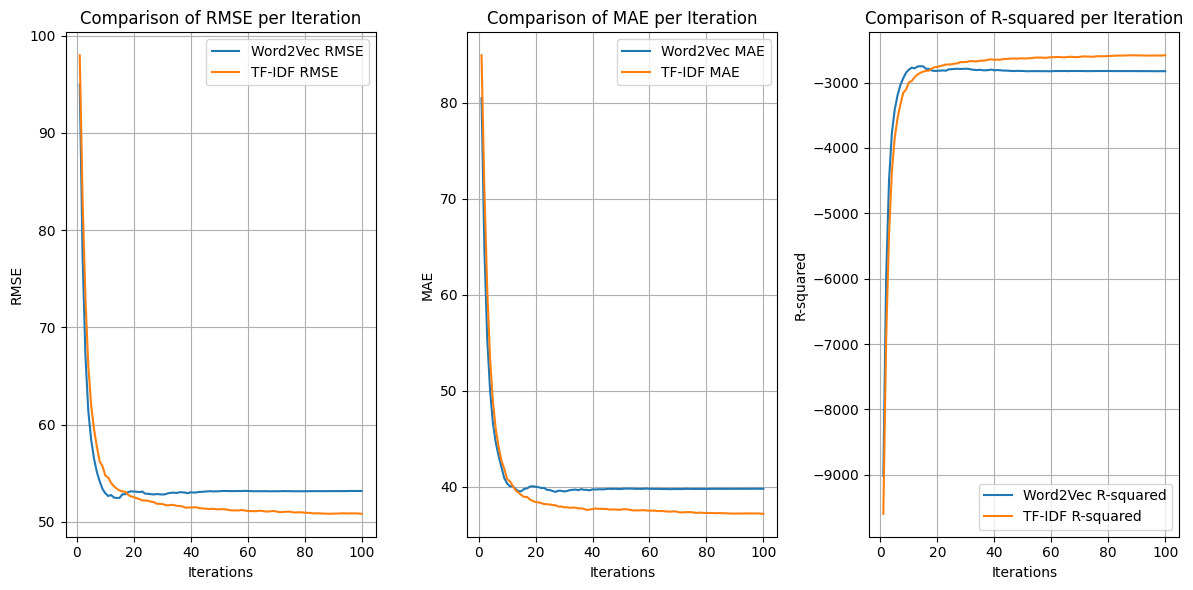

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Tokenize the text data for Word2Vec
tokenized_data = [text.split() for text in train_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=400, window=9, min_count=1, workers=12)

# Convert text data to Word2Vec embeddings
def get_text_embedding(text, model):
    embedding = [model.wv[word] for word in text.split() if word in model.wv]
    if embedding:
        return sum(embedding) / len(embedding)
    else:
        return np.zeros(400)  # Adjusted to match vector_size

train_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in train_data])
test_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in test_data])

# Train and evaluate XGBoost with Word2Vec
xgb_model_wv = XGBRegressor()
eval_set_wv = [(test_text_features_wv, test_labels)]
xgb_model_wv.fit(train_text_features_wv, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_wv, verbose=True)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Train and evaluate XGBoost with TF-IDF
xgb_model_tfidf = XGBRegressor()
eval_set_tfidf = [(test_text_features_tfidf, test_labels)]
xgb_model_tfidf.fit(train_text_features_tfidf, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_tfidf, verbose=True)

# Get evaluation results for Word2Vec
results_wv = xgb_model_wv.evals_result()
rmse_wv = results_wv['validation_0']['rmse']
mae_wv = results_wv['validation_0']['mae']
r_squared_wv = [1 - (rmse ** 2) for rmse in rmse_wv]
epochs_wv = range(1, len(rmse_wv) + 1)

# Get evaluation results for TF-IDF
results_tfidf = xgb_model_tfidf.evals_result()
rmse_tfidf = results_tfidf['validation_0']['rmse']
mae_tfidf = results_tfidf['validation_0']['mae']
r_squared_tfidf = [1 - (rmse ** 2) for rmse in rmse_tfidf]
epochs_tfidf = range(1, len(rmse_tfidf) + 1)

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_wv, rmse_wv, label='Word2Vec RMSE')
plt.plot(epochs_tfidf, rmse_tfidf, label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_wv, mae_wv, label='Word2Vec MAE')
plt.plot(epochs_tfidf, mae_tfidf, label='TF-IDF MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_wv, r_squared_wv, label='Word2Vec R-squared')
plt.plot(epochs_tfidf, r_squared_tfidf, label='TF-IDF R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


[0]	validation_0-rmse:89.01627	validation_0-mae:76.16149
[1]	validation_0-rmse:68.67426	validation_0-mae:57.78299
[2]	validation_0-rmse:55.05228	validation_0-mae:45.54295
[3]	validation_0-rmse:46.15350	validation_0-mae:37.29097
[4]	validation_0-rmse:40.72564	validation_0-mae:31.85735
[5]	validation_0-rmse:37.44709	validation_0-mae:28.32438
[6]	validation_0-rmse:35.45168	validation_0-mae:26.06393
[7]	validation_0-rmse:34.09458	validation_0-mae:24.59163
[8]	validation_0-rmse:33.13501	validation_0-mae:23.51686
[9]	validation_0-rmse:32.29151	validation_0-mae:22.75241
[10]	validation_0-rmse:31.76464	validation_0-mae:22.26127
[11]	validation_0-rmse:31.36080	validation_0-mae:21.88384
[12]	validation_0-rmse:30.92057	validation_0-mae:21.50369
[13]	validation_0-rmse:30.59943	validation_0-mae:21.23932
[14]	validation_0-rmse:30.37316	validation_0-mae:21.03305
[15]	validation_0-rmse:30.13090	validation_0-mae:20.84794
[16]	validation_0-rmse:29.96266	validation_0-mae:20.72493
[17]	validation_0-rmse:2

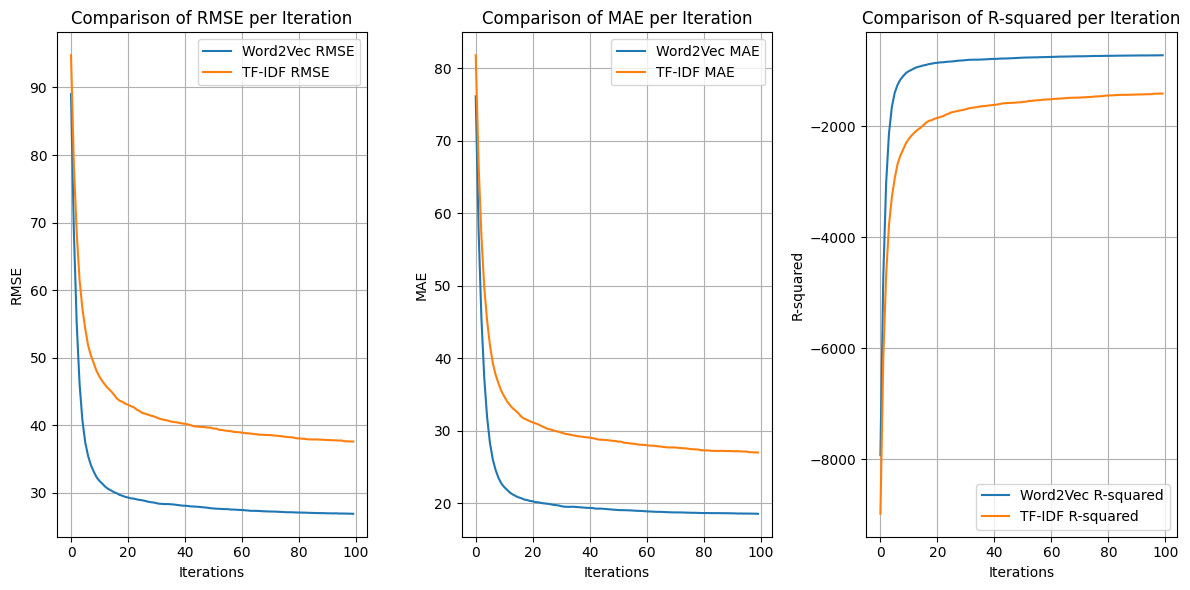

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Tokenize the text data for Word2Vec
tokenized_data = [text.split() for text in train_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=400, window=9, min_count=1, workers=4)

# Convert text data to Word2Vec embeddings
def get_text_embedding(text, model):
    embedding = [model.wv[word] for word in text.split() if word in model.wv]
    if embedding:
        return sum(embedding) / len(embedding)
    else:
        return np.zeros(400)  # Adjusted to match vector_size

train_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in train_data])
test_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in test_data])

# Train and evaluate XGBoost with Word2Vec
xgb_model_wv = XGBRegressor()
eval_set_wv = [(test_text_features_wv, test_labels)]
xgb_model_wv.fit(train_text_features_wv, train_labels, eval_metric=["rmse", "mae"], eval_set=eval_set_wv, verbose=True)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Train and evaluate XGBoost with TF-IDF
xgb_model_tfidf = XGBRegressor()
eval_set_tfidf = [(test_text_features_tfidf, test_labels)]
xgb_model_tfidf.fit(train_text_features_tfidf, train_labels, eval_metric=["rmse", "mae"], eval_set=eval_set_tfidf, verbose=True)

# Get evaluation results for Word2Vec
results_wv = xgb_model_wv.evals_result()
epochs_wv = len(results_wv['validation_0']['rmse'])
x_axis_wv = range(0, epochs_wv)

# Get evaluation results for TF-IDF
results_tfidf = xgb_model_tfidf.evals_result()
epochs_tfidf = len(results_tfidf['validation_0']['rmse'])
x_axis_tfidf = range(0, epochs_tfidf)

# Calculate R-squared for Word2Vec
rmse_wv = results_wv['validation_0']['rmse']
r_squared_wv = [1 - (rmse ** 2) for rmse in rmse_wv]

# Calculate R-squared for TF-IDF
rmse_tfidf = results_tfidf['validation_0']['rmse']
r_squared_tfidf = [1 - (rmse ** 2) for rmse in rmse_tfidf]

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(x_axis_wv, results_wv['validation_0']['rmse'], label='Word2Vec RMSE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['rmse'], label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(x_axis_wv, results_wv['validation_0']['mae'], label='Word2Vec MAE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['mae'], label='TF-IDF MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(x_axis_wv, r_squared_wv, label='Word2Vec R-squared')
plt.plot(x_axis_tfidf, r_squared_tfidf, label='TF-IDF R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [78]:
predictions_wv = xgb_model_wv.predict(test_text_features_wv)

# Making predictions with the TF-IDF model
predictions_tfidf = xgb_model_tfidf.predict(test_text_features_tfidf.toarray()) 

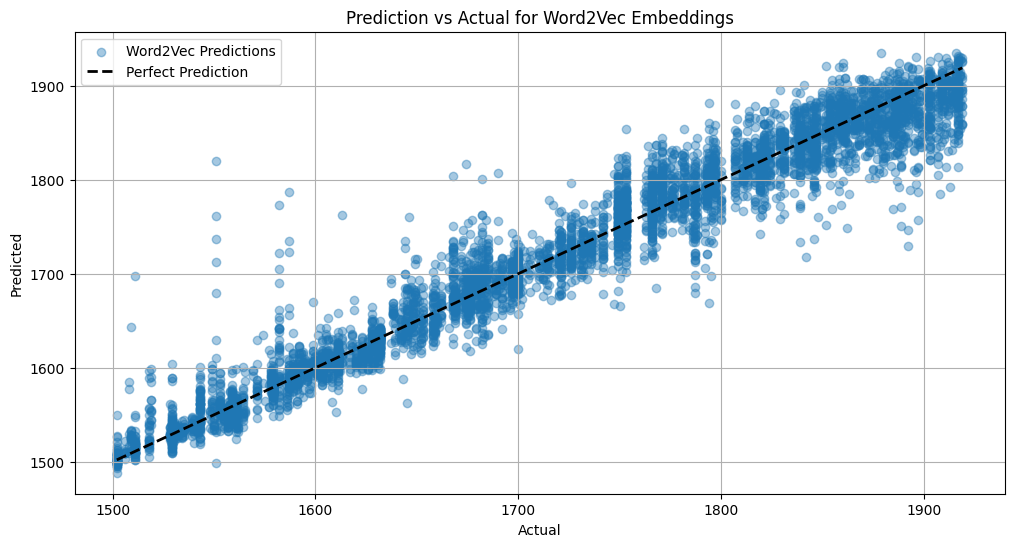

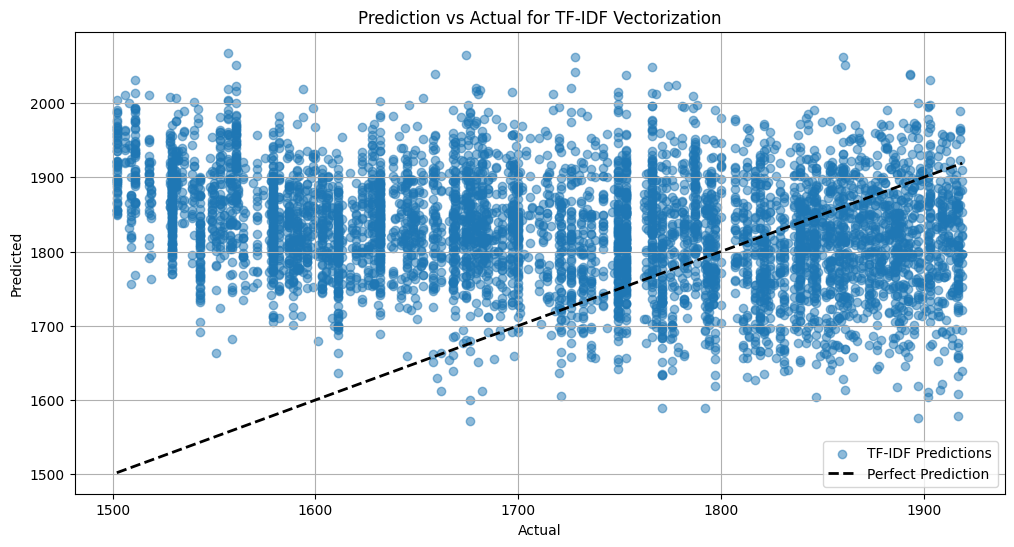

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_wv, alpha=0.4, label='Word2Vec Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for Word2Vec Embeddings')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Prediction vs Actual for TF-IDF
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_tfidf, alpha=0.5, label='TF-IDF Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for TF-IDF Vectorization')
plt.legend()
plt.grid(True)
plt.show()

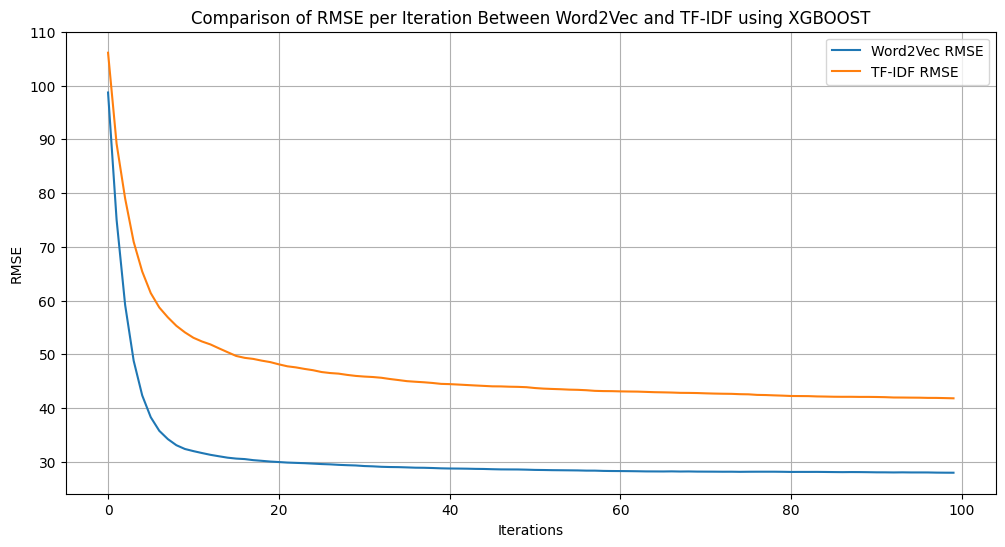

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

# Assuming x_axis_wv, results_wv['validation_0']['rmse'], x_axis_tfidf, results_tfidf['validation_0']['rmse'] are defined
plt.figure(figsize=(12, 6))
plt.plot(x_axis_wv, results_wv['validation_0']['rmse'], label='Word2Vec RMSE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['rmse'], label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration Between Word2Vec and TF-IDF using XGBOOST')
plt.legend()
plt.grid(True)

# To display the chart on screen
plt.show()

# To save the figure with a transparent background
plt.savefig('comparison_chart_transparent.png', transparent=True)


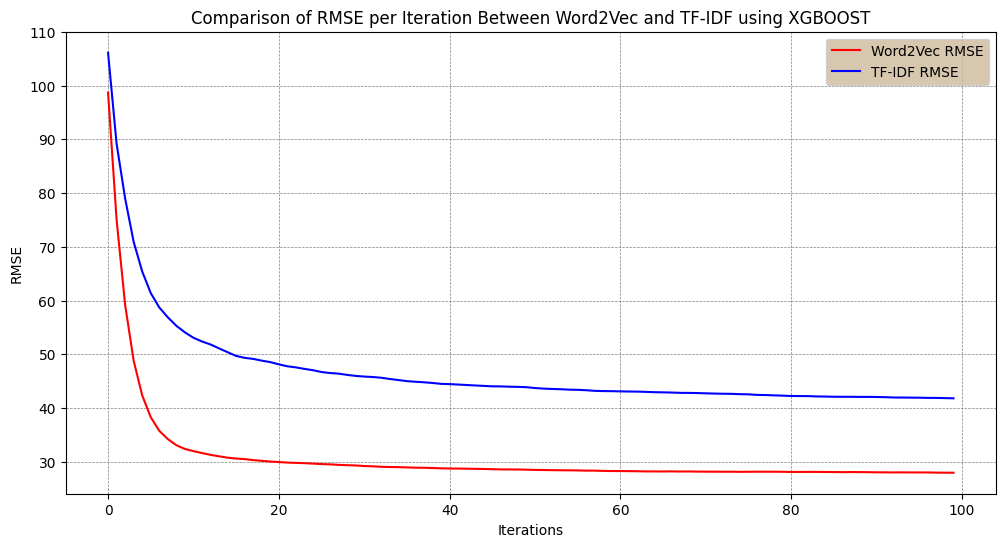

<Figure size 640x480 with 0 Axes>

# SHAP FOR NON_BERT MODELS

In [54]:
shap_text = ["untouched many surprising events and turns of fortune which for their infinite variety could not be contained in this little book besides a world of sprightly and cheerful characters both men and women the humor of which it was feared would be lost if it were attempted to reduce the length of them What these Tales shall have been to the YOUNG readers that and much more it is the writers ' wish that the true Plays of Shakespeare may prove to them in older years enrichers of the fancy strengtheners of virtue a withdrawing from all selfish and mercenary thoughts a lesson of all sweet and honorable thoughts d actions to teach courtesy benignity generosity humanity for of examples teaching these virtues his pages are full THE TEMPEST There was a certain island in the sea the only inhabitants of which were an old man whose name was Prospero and his daughter Miranda a very beautiful young lady She came to this island so young that she had no memory of having seen any other human face than her father 's They lived in a cave or cell made out of a rock it was divided into several apartments one of which Prospero called his study there he kept his books which chiefly treated of magic a study at that time much affected by all learned men and the knowledge of this art he found very useful to him for being thrown by a strange chance upon this island which had been enchanted by a witch called Sycorax who died there a short time before his arrival Prospero by virtue of his art released many good spirits that Sycorax had imprisoned in the bodies of large trees because they had refused to execute her wicked commands These gentle spirits were ever after obedient to the will of Prospero Of these Ariel was the chief The lively little sprite Ariel had nothing mischievous in his nature except that he took rather too much pleasure in tormenting an ugly monster called Caliban for be owed him a grudge because he was the son of his old enemy Sycorax This Caliban Prospero found in the woods a strange misshapen thing far less human in form than an ape he took him home to his cell and taught him to speak and Prospero would have been very kind to him but the bad nature which Caliban inherited from his mother Sycorax would not let him learn anything good or useful therefore he was employed like a slave to fetch wood and do the most laborious offices and Ariel had the charge of compelling him to these services When Caliban was lazy and neglected his work Ariel who was invisible to all eyes but Prospero 's would come slyly and pinch him and sometimes tumble him down in the mire and then Ariel in the likeness of an ape would make mouths at him Then swiftly changing his shape in the likeness of a hedgehog he would lie tumbling in Caliban 's way who feared the hedgehog 's sharp quills would prick his bare feet With a variety of such like vexatious tricks Ariel would often torment him whenever Caliban neglected the work which Prospero commanded him to do Having these powerful spirits obedient to his will Prospero could by their means command the winds and the waves of the sea By his orders they raised a violent storm in the midst of which and struggling with the wild sea waves that every moment threatened to swallow it up he showed his daughter a fine large ship which he told her was full of living beings like themselves O my dear father '' said she if by your art you have raised this dreadful storm have pity on their sad distress See the vessel will be dashed to pieces Poor souls they will all perish If I had power I would sink the sea beneath the earth rather than the good ship should be destroyed with all the precious souls within her '' Be not amazed daughter Miranda '' said Prospero there is no harm done I have so ordered it that no person in the ship shall receive any hurt What I have done has been in care of you my dear child You are ignorant who you are or where you came from and you know no more of me but that I am your father and live in this poor cave",
 "chaunce He challenged with him to breake a launce 9The gallant youth that neuer man refused Straight turnd his horse a space for course to take As one that for his time had often vsed Such feates as this to do and vndertake Renaldostandeth still and them perused To see which knight the fairest course would make NowRichardetthinks if I hit him iust I shall this gallant tumble in the dust 10But otherwise it then to him befell And of his reckning he was quite deceaued The tother knew to hit and sit so well ThatRichardetwas from the sadle heaued Alardoseeing how his brother fell Did thinke t'auenge the foile that he receaued But he likewise inferiour did remaine His arme was bruisd his shield was rent in twaine 11Guicchiardonext the selfe same fortune tride And was constraind the ground t'encline Although to himRenaldolowdly cride Stay hold your hands for this course should be mine VivianandMalagige and more beside That at their kinsmens foyle did much repine Would then fought with this same stranger knight Saue thatRenaldoclaymd it as his right 12And said my friends we must to Paris hast But to himselfe he said it were a iest would not upbraid For me to stay till all they downe were castBy one and one lle fight and they shall rest This said he spurres his horse and commeth fast And as he runs he sets his speare in rest The tother doth as much and eithers speare The stroke doth in a thousand peeces teare 13The horsemen with the stroke stur not an inch They both had learnd so perfectly to fit But on their horses it did shrowdly pinch Yet Bayard searce his course doth intermit The tothers horse had such a parlous wrinch That mard him quite and brake his backe with it His master that was greatly grieu'd to see't Forsakes his seate and takes him to his feet 14And toRenaldo that with naked handCame toward him in shew of truce he sed Sir knight I giue you here to vnderstand I likt so well this horse that here is ded I thinke it would not with mine honor stand To leaue him vnreuengd which hath me ledTo challenge you eu'n as you are true knight That you will answer me againe in fight 15Renaldoanswerd if your horse you lost The onely cause of this your quarrell be Then comfort you for of mine onely cost Your want herein shall be supplide by me With such a horse as I may boldly bost To be as good a one as cre was he Not so fit said the tother you mistake it I will expound my mind and plainer make it 16Though I lykt well my seruiceable horse Yet fith he now is in this conflict flame Thinke not that of his death I so much force As that alone moues me to fight againe But in plaine termes on foot to true your force As well as erst on horsebacke I would saine Renaldo that of no mans force accounted Without delay straight from his horse dismounted 17And fith quoth he I see your noble mind Of this my company hath no suspition They shall go on and I will stay behind And so will fight with you on eu'n condition This said his band to part thence he assignd Who went their way vpon their Lords commission Which bred great admiration in the stranger To find a man so little fearing danger 18Now when his standerd quite was out of sight And allRenaldoscompanie was gone Then hand to hand they do apply the fight With force and furie great they lay it on Each maruels at the tothers passing might And yet of either side the gaine is none They felt the blowes so heauie and so hard That glad they were to lie well to their ward 19Thus these two knights for honors onely sake Together combat in such eager fort That eu'ry little error they should make Endangerd life in this vnpleasant sport An houre and halfe this trauell they did take Each labouring to cut the tother short And in his mindRenaldomaruels much Who this should be whose skill and force was such 20And saue that he could not with his reputation He would wisht the battell at an end And offerd of a truce communication And of his vnknowne foe made his frend Likewise the tother felt such inclination Now",
 "way did stand 24This Orke for so men do the monster call Directed straight his course vpon our tent His eyes were out how ere it did befall But yet he was so quicke and sharpe of sent As all his blindnesse holpe not vs at all He hunteth like a spaniell by the vent His sent is such as none can hope to shunne him His pace is such as no man can outrunne him 25 Thus whether they prepar'd to fight or fly Or whether feare both sight and flight did let He takes them as his prisners by and by Of fortie ten scarce to the ship could get Among the other prisners tane was I Whilst I our Queene in safetie would set But all in vaine to flie it did not boote He was so quicke of sent aud swift of foote 26As shepheards hang a wallet at their wast So at his gudle hangs a mightie sacke In which the better sort of vs he plast The rest he bound together in a packe And to his caue that was most huge and vast He beares vs hopelesse euer to come backe A comely matron in this den he had Maids faire and foule some poore some richly clad 27Beside this female family of his He hath a caue wherein he keepes his flocke That caue in length and largenesse passeth this Made all by hand out of the stonie rocke And for mans flesh his chiefest daintie is Into the caue he safely doth vs locke The while he leades abroade his goates and sheepe Which in the fields adioyning he doth keepe 28The King not knowing this returned backe The silence that he found some feare did breed But when he found his wife and men were lacke He then to sea did hast him with great speed He sees plaine signes of hast of spoyle of wracke Yet knowes he not the author of this deed Vntill he had his ship by hap recouered Then by his men the fact was plaine discouered 29When he had heard at last the wofull newes How greatly was his heart surprysd with griefe What gods what fortune did he not accuse For all his losses butLucynachiefe But dangers all and death he first will chuse Ere he then leaue his loue without reliefe He either will her libertie procure Or else he will like chance with her endure 30He leaues his ship and goes by land apace There where the monster had his loue conuaid And often wailes her hard and wofull case Desiring and despairing of her aid Now came he in the kenning of the place And stands twixt halfe amazd and halfe afraid At last he enters loue expelling feare When by good hap the monster was not there 31His wife was there who with compassion moued Admonisht him to make but little stay But hasten thence if so his life he loued Lest that her husband find him in the way Yet from his purpose this him not remoued But to the sober matron he doth say In vaine you seeke to driue me hence by terror Desire hath hither brought me and not error 32By my ill hap while I abroade was riding The Orko bare away my dearest wife I hither come of her to heare some tiding Or hauing lost my loue to leese my life I care not I if she in life be biding If she be dead my death shall end this strife Loue in this point so resolute hath made me You should but leese your labour to distwade me 33The gentle matron in this sort replies Know this thy wife in safetie doth remaine But hard it is to compasse or deuise Which way to get her from his hand againe His want of fight his passing sent supplies To striue with him by force it were but vaine He spoileth men but women do not die Saue onely such as striue away to flie 34But those he finds his companie to shunne With hatred gr e doth for ay pursew Some he doth hang ail naked in the sunne And day by day their torments doth renew And some immediatly to death are done Both yong and old both foule or faire of hew So that to seeke to setLucynafree May harme her much and little profit thee 35Wherefore my sonne",
 "settlement by continuing forty days after publication of notice in writing is very seldom obtained and the design of the acts is not so much for gaining of settlements as for the avoiding of them by persons coming into a parish clandestinely for the giving of notice is only putting a force upon the parish to remove But if a person 's situation is such that it is doubtful whether he is actually removable or not he shall by giving of notice compel the parish either to allow him a settlement uncontested by suffering him to continue forty days or by removing him to try the right '' This statute therefore rendered it almost impracticable for a poor man to gain a new settlement in the old way by forty days inhabitancy But that it might not appear to preclude altogether the common people of one ' parish from ever establishing themselves with security in another it appointed four other ways by which a settlement might be gained without any notice delivered or published The first was by being taxed to parish rates and paying them the second by being elected into an annual parish office and serving in it a year the third by serving an apprenticeship in the parish the fourth by being hired into service there for a year and continuing in the same service during the whole of it Nobody can gain a settlement by either of the two first ways but by the public deed of the whole parish who are too well aware of the consequences to adopt any new comer who has nothing but his labour to support him either by taxing him to parish rates or by electing him into a parish office No married man can well gain any settlement in either of the two last ways An apprentice is scarce ever married and it is expressly enacted that no married servant shall gain any settlement by being hired for a year The principal effect of introducing settlement by service has been to put out in a great measure the old fashion of hiring for a year which before had been so customary in England that even at this day if no particular term is agreed upon the law intends that every servant is hired for a year But masters are not always willing to give their servants a settlement by hiring them in this manner and servants are not always willing to be so hired because as every last settlement discharges all the foregoing they might thereby lose their original settlement in the places of their nativity the habitation of their parents and relations No independent workman it is evident whether labourer or artificer is likely to gain any new settlement either by apprenticeship or by service When such a person therefore carried his industry to a new parish he was liable to be removed how healthy and industrious soever at the caprice of any churchwarden or overseer unless he either rented a tenement of ten pounds a year a thing impossible for one who has nothing but his labour to live by or could give such security for the discharge of the parish as two justices of the peace should judge sufficient What security they shall require indeed is left altogether to their discretion but they can not well require less than thirty pounds it having been enacted that the purchase even of a freehold estate of less than thirty pounds value shall not gain any person a settlement as not being sufficient for the discharge of the parish But this is a security which scarce any man who lives by labour can give and much greater security is frequently demanded In order to restore in some measure that free circulation of labour which those different statutes had almost entirely taken away the invention of certificates was fallen upon By the 8th and 9th of William III it was enacted that if any person should bring a certificate from the parish where he was last legally settled subscribed by the church wardens and overseers of the poor and allowed by two justices of the peace that every other parish should be obliged to receive him that he should not be removable merely upon account of his being likely to become chargeable but only upon his becoming actually chargeable and that then the parish which granted the certificate should be obliged to pay the expense both of his maintenance and",
 "the connexion as uniform which happened to occur in that particular instance In the same manner it will appear that a false impression may be conveyed respecting the conduct of an individual by assigning motives which are entirely imaginary by connecting things together which have no relation by keeping out of view circumstances which would afford an explanation or palliation of his conduct or by Pg 81 attaching to his words a different meaning from that which he intended to convey by them The common saying that there are two ways of telling a story does not therefore refer to what is strictly to be called fabrication or falsehood but to those distortions or colourings of circumstances which however slight in themselves have the effect of essentially changing the impression made by the whole To veracity under this department we are also to refer the rule of giving to others an honest and fair impression of our views motives and intentions This is Sincerity It is opposed to hypocrisy that unworthy display of human character in which a man disguises his real sentiments and on the contrary professes principles which he neither feels nor values merely for the purpose of promoting his selfish interests Such a character exhibits a singular combination of moral delinquencies It is founded on the lowest selfishness and includes a departure from veracity and honesty But besides it implies a knowledge of virtuous principles and of their proper tendencies while there is a practical denial of their Pg 82 influence Sincerity is also opposed to flattery which tends to give a man a false impression of our opinion and of our feelings towards him and likewise leads him to form a false estimate of his own character It is opposed also to simulation or double dealing by which a man for certain purposes professes sentiments towards another which he does not feel or intentions which he does not entertain 3 The third element of veracity is Truth of Purpose or fidelity in the fulfilment of promises This is opposed to actual departure from what was distinctly promised likewise to all those evasions by which one may convey an impression or excite the hope of an intention which he does not mean to fulfil or avoid the performance of a real or implied engagement on any other ground than inability to perform it By this straight forward integrity of purpose an individual gives a clear impression of what he honestly intends to perform and performs it though circumstances may have occurred to make the fulfilment disagreeable or even injurious to himself he sweareth to Pg 83 his own hurt '' says a sacred writer and changeth not '' IV FRIENDSHIP LOVE AND GRATITUDE These affections are so nearly allied that in this slight analysis they may be taken together They consist in a personal and peculiar attachment to an individual founded either upon some qualities in himself or some benefits he has conferred on us or on some one in whom we are interested The feelings and conduct to which they give rise correspond with those referred to under the preceding affections with this difference that in many instances they lead to a much greater sacrifice of personal interest and comfort than usually proceeds either from justice or simple benevolence The exertions arising out of them are directed according to the division formerly given to promoting the interest or comfort of the object of our regard preserving defending or advancing his reputation treating his feelings with peculiar tenderness and his failings with peculiar Pg 84 indulgence receiving his opinions with peculiar favour and anxiously endeavouring to improve his intellectual and moral condition This last consideration is justly reckoned the highest office of friendship it is to be regretted that its operation is sometimes impeded by another feeling which leads us to be blind to the failings and deficiencies of those whom we love In exercising simple love and friendship we rejoice in the advantage and happiness of the object though they should be accomplished by others but in exercising gratitude we are not satisfied unless they be effected in some measure by ourselves V PATRIOTISM Patriotism is perhaps not properly to be considered as a distinct principle of our nature but rather as a result of a combination of the other affections It leads us by every means in our power to promote the peace and the prosperity of our country and to discourage to the utmost",
 "his tragedy and therefore shines in the passionate parts more than any of our English poets As there is something familiar and domestic in the fable of his tragedy he has little pomp but great energy in his expressions for which reason though he has admirably succeeded in the tender and melting parts of his tragedies he sometimes falls into too great a familiarity of phrase in those which by Aristotle 's rule ought to have been raised and supported by the dignity of expression It has been observed by the critics that the poet has founded his tragedy of Venice Preservcd on so wrong a plot that the greatest characters in it are those of rebels and traitors Had the hero of this play discovered the same good qualities in defence of his country that he shewed for his ruin and subversion the audience could not enough pity and admire him but as he is now represented we can only say of him what the Roman historian says of Catiline that his fall would have been glorious si pro Patria sic concidisset had he so fallen in the service of his country Mr Charles Gildon in his Laws of Poetry stiles Mr Otway a Poet of the first Magnitude and tells us and with great justice that he was perfect master of the tragic passions and draws them every where with a delicate and natural simplicity and therefore never fails to raise strong emotions in the soul I do n't know of a stronger instance of this force than in the play of the Orphan the tragedy is composed of persons whose fortunes do not exceed the quality of such as we ordinarily call people of condition and without the advantage of having the scene heightened by the importance of the characters his inimitable skill in representing the workings of the heart and its affection is such that the circumstances are great from the art of the poet rather than from the figure of the persons represented The whole drama is admirably wrought and the mixture of passions raised from affinity gratitude love and misunderstanding between brethren ill usage from persons obliged slowly returned by the benefactors keeps the mind in a continual anxiety and contrition The sentiments of the unhappy Monimia are delicate and natural she is miserable without guilt but incapable of living with a consciousness of having committed an ill act though her inclination had no part in it Mrs Barry the celebrated actress used to say that in her part of Monimia in the Orphan she never spoke these words Ah poor Castalio without tears upon which occasion Mr Gildon observes that all the pathetic force had been lost if any more words had been added and the poet would have endeavoured in vain to have heightened them by the addition of figures of speech since the beauty of those three plain simple words is so great by the force of nature that they must have been weakened and obscured by the finest flowers of rhetoric The tragedy of the Orphan is not without great blemishes which the writer of a criticism on it published in the Gentleman 's Magazine has very judiciously and candidly shewn The impetuous passion of Polydore breaks out sometimes in a language not sufficiently delicate particularly in that celebrated passage where he talks of rushing upon her in a storm of love The simile of the bull is very offensive to chaste ears but poor Otway lived in dissolute times and his necessity obliged him to fan the harlot face of loose desire in compliance to the general corruption Monimia staying to converse with Polydor after he vauntingly discovers his success in deceiving her is shocking had she left him abruptly with a wildness of horror that might have thrown him under the necessity of seeking an explanation from Castalio the scene would have ended better would have kept the audience more in suspence and been an improvement of the consequential scene between the brothers but this remark is submitted to superior judges Venice Preferred is still a greater proof of his influence over our passions and the faculty of mingling good and bad characters and involving their fortunes seems to be the distinguished excellence of this writer He very well knew that nothing but distressed virtue can strongly touch us with pity and therefore in this play that we may have a greater regard for the conspirators he makes",
 'Obiection I see not why it should breed any when none is bound to beleeue that they write nor they looke not to their fictions beleeued in the literall sence aud therefore he that well examine whence errours spring shall finde the writers of prose not of verse the authors and maintainers of them and this point I count so manifest as it needes no proofe The last reproofe is lightnes and wantonnes this is indeed an Obiection of some importance sith as SirPhilip Sidneyconfesseth Cupidois crept euen into the Heroicall Poemes consequently maketh that also subiect to this reproofe I promised in the beginning not partially to praise Poesie but plainly and honestly to confesse that that might truely be obiected against it and if any thing may be sure it is this lasciuiousnesse yet this I will say that of all kinde of Poesie the Heroicall is least infected therewith The other kindes I will rather excuse then defend though of all the kindes of Poesie it may be sayd where any scurrilitie and lewdnesse is found there Poetrie doth not abuse vs but writers abused Poetrie And brieflie to examine all the kindes First the Tragicall is meerely free from it as representing onely the cruell and lawlesse proceedings of Princes mouing nothing but pitie or detestation The Comicall whatsoeuer foolish play makers make it offend in this kind yet being rightly vsed it represents themso as to make the vice scorned and not embraced The Satyrike is meerly free from it as being wholy occupied in mannerly and couertly reprouing of all vices The Elegie is stil mourning as for the Pastorall with the Sonnet or Epigramme though many times they sauour of wantonnesse and loue and toying and now and then breaking the rules of Poetrie go into plaine scurrilitie yet euen the worst of them may be not ill applied and are I must confesse too delightfull in so much asMartialsaith Laudant illa sed ista legunt And in another place Erubuit posuitque meum Lucrecia librum Sed coram Bruto Brute recede leget Lucrecia by which he signifies any chast matron will blush and be ashamed to reade a lasciuious booke but how not exceptBrutusbe by that is if any graue man should see her reade it but ifBrutusturne his backe she will to it againe and reade it all But to end this part of my Apologie as I count and conclude Heroicall Poesie allowable and to be read and studied without all exception so may I boldly say that Tragedies well handled be a most worthy kind of Poesie that Comedies may make men see and shame at their owne faults that the rest may be so written and so read as much pleasure and some profite may be gathered out of them And for mine owne part asScaligerwriteth ofVirgil so I beleeue that the reading of a good Heroicall Poeme may make a man both wiser and honester and for Tragedies to omit other famous Tragedies that that which was played at SaintIohnsin Cambridge ofRichardthe third would moue I thinke Phalaristhe tyrant and terrifie all tyrannous minded men from following their foolish ambitious humors seeing how his ambition made him kill his brother his nephewes his wife beside infinite others and last of all after a short and troublesome raigne to end his miserable life and to his bodie harried after his death Then for Comedies how full of harmelesse mirth is our Cambridge Pedantius and the Oxford Bellum Grammaticale or to speake of a London Comedie how much good matter yea and matter of state is there in that Comedie called the play of the Cards in which it is shewed how foure Parasiticall knaues robbe the foure principall vocations of the Realme videl the vocation of Souldiers Schollers Merchants and Husbandmen Of which Comedie I cannot forget the saying of a notable wise counseller that is now dead who when some to singPlacebo aduised that it should be forbidden because it was somewhat too plaine Sir Frances VValsingham and indeed as the old saying is sooth boord is no boord yet he would it allowed adding it was fit thatthey which do that they should not should heare that they wold not Finally if Comedies may be so made as the beholders may be bettered by them without all doubt all other sorts of Poetrie may bring their profite as they do bring delight and if all then much more the',
 '  Few better atmospheres could be even imagined for the combined novelromancethe story which  while it did not exclude the adventurous or even the supernatural in one sense  insisted on the rational in another  and opened its doors as wide as possible to every subject  or combination of subjects  that would undertake to be interesting  That the extraordinary reply made by genius and talent to the demand thus created and encouraged should last indefinitely could not be expected that the demand itself should lead to overproduction and glut was certain  But  as we shall see  there was no sudden decadence  the period even of best or nearly best production went on with no important intermission  and was but yesterday still represented by two great names  is still represented by one  among the older writers  by more than one or two names of credit among the middleaged and younger  To these in some degree  and to those who have finished their career in the last thirty years to a greater  we must now turn  CHAPTER VIIITHE FICTION OF YESTERDAYCONCLUSIONIn regard to a large part of the subject of the present chapter the present writer possesses the knowledge of a reviewer  week by week and almost day by day  of contemporary fiction between and  It so happened that the beginning of this period coincided very nearly with the beginning of that slightly downward movement of the nineteenthcentury novel which has been referred to at the end of the last chapter and he thus had opportunities of observing it all along its course  till we parted company  It must again  and most strongly  be insisted that this downward movement  like such movements generally in literature  is only so to be characterised with considerable provisos and allowances  Literary downgrades are not like the slopes of an inclined plane they are like portions of a mountain range  in which isolated peaks may shoot up almost level with the very highest of the central group  but in which the table lands are lower  the average height of the hills inferior  and the general skyline a nearer and nearer approximation to the plain  At the actual death of Dickens there was no reason for any one less hopelessly pessimist than Peacocks Mr  Toobad  or Sydney Smiths Tuxford waiter  to take a gloomy view of the future of the novel  Of the greater novelists mentioned in the last chapter Charlotte Bronte and Mrs  Gaskell were indeed dead  and if Kingsley had not wholly ceased writing novels  he had  before ceasing  given signs that he had better do so  Yet  at least to the admirers of George Eliot  she was at her most admirable  some of the very best stuff of Trollope was but just past  and some of all but his best was still to appear  Charles Reade was writing busily with that curious unsatisfactory genius of his  others were well at work  There was also no lack of newer comers  Mr  Meredith had been writing for some dozen years and though he had achieved no general popularity  though even critics might make reserves as to points in his procedure  there could be no competent doubt of his great powers     ',
 "him but only chucking her under the chin he went on Ay ay my little duck never mind 'em one of 'em i 'n' t worth a penny and t other has nothing in his pockets but lists of the defunct What good will come of that would not give twopence a dozen for 'em A poor set of grandees with nothing but a tie wig for their portions '' Cecilia unable to bear this harangue in the presence of young Delvile who however laughed it off with a very good grace arose with an intention to retreat which being perceived by Sir Robert Floyer who had attended to this dialogue with haughty contempt he came forward and said now then madam may I have the honour of your hand '' No Sir '' answered Cecilia I am engaged '' Engaged again '' cried he with the air of a man who thought himself much injured Glad of it glad of it '' said Mr Briggs served very right have nothing to say to him my chick '' Why not Sir '' cried Sir Robert with an imperious look Sha 'n' t have her sha 'n' t have her can tell you that wo n't consent know you of old '' And what do you know of me pray Sir '' No good no good nothing to say to you found fault with my nose ha 'n' t forgot it '' At this moment Mr Marriot came to claim his partner who very willing to quit this scene of wrangling and vulgarity immediately attended him Miss Larolles again flying up to her said O my dear we are all expiring to know who that creature is I never saw such a horrid fright in my life '' Cecilia was beginning to satisfy her but some more young ladies coming up to join in the request she endeavoured to pass on O but '' cried Miss Larolles detaining her do pray stop for I 've something to tell you that 's so monstrous you 've no idea Do you know Mr Meadows has not danced at all and he 's been standing with Mr Sawyer and looking on all the time and whispering and laughing so you 've no notion However I assure you I 'm excessive glad he did not ask me for all I have been sitting still all this time for I had a great deal rather sit still I assure you only I 'm sorry I put on this dress for any thing would have done just to look on in that stupid manner '' Here Mr Meadows sauntered towards them and all the young ladies began playing with their fans and turning their heads another way to disguise the expectations his approach awakened and Miss Larolles in a hasty whisper to Cecilia cried Pray do n't take any notice of what I said for if he should happen to ask me I ca n't well refuse him you know for if I do he 'll be so excessive affronted you ca n't think '' Mr Meadows then mixing in the little group began with sundry grimaces to exclaim how intolerably hot it is there 's no such thing as breathing How can anybody think of dancing I am amazed Mr Harrel has not a ventilator in this room Do n't you think it would be a great improvement '' This speech though particularly addressed to no one received immediately an assenting answer from all the young ladies Then turning to Miss Larolles Do n't you dance '' he said Me '' cried she embarrassed yes I believe so really I do n't know I a 'n' t quite determined '' O do dance '' cried he stretching himself and yawning it always gives me spirits to see you '' Then turning suddenly to Cecilia without any previous ceremony of renewing his acquaintance either by speaking or bowing he abruptly said Do you love dancing ma'am '' Yes Sir extremely well '' I 'm very glad to hear it You have one thing then to soften existence '' Do you dislike it yourself '' What dancing Oh dreadful how it was ever adopted in a civilized country I can not find out 't is certainly a Barbarian exercise and of savage origin Do n't you think so Miss Larolles '' Lord no '' cried Miss Larolles I assure you I like it better than any thing I",
 "should we shift estates yours would be mine The ingratitude of thisSeleucus doesEuen make me wilde Oh Slaue of no more trustThen loue that's hyr'd What goest thou backe thoushaltGo backe I warrant thee but Ile catch thine eyesThough they had wings Slaue Soule lesse Villain Dog O rarely base Caesar Good Queene let vs intreat you Cleo OCaesar what a wounding shame is this That thou vouchsafing heere to visit me Doing the Honour of thy LordlinesseTo one so meeke that mine owne Seruant shouldParcell the summe of my disgraces byAddition of his Enuy Say goodCaesar That I some Lady trifles reseru'd Immoment toyes things of such DignitieAs we greet moderne Friends withall and saySome Nobler token I kept apartForLiuiaandOctauia to induceTheir mediation must I be vnfoldedWith one that I bred The Gods it smites meBeneath the fall I Prythee go hence Or I shall shew the Cynders of my spiritsThrough th' Ashes of my chance Wer't thou a man Thou would'st mercy on me Caesar ForbeareSeleucus Cleo Be it known that we the greatest are mis thoghtFor things that others do and when we fall We answer others merits in our nameAre therefore to be pittied Caesar Cleopatra Not what you reseru'd nor what acknowledg'dPut we i'th' Roll of Conquest still bee't yours Bestow it at your pleasure and beleeueCaesars no Merchant to make prize with youOf things that Merchants sold Therefore be cheer'd Make not your thoughts your prisons No deere Queen For we intend so to dispose you asYour selfe shall giue vs counsell Feede and sleepe Our care and pitty is so much vpon you That we remaine your Friend and so adieu Cleo My Master and my Lord Caesar Not so Adieu Flourish Exeunt Caesar and his Traine Cleo He words me Gyrles he words me That I should not be Noble to my selfe But hearke theeCharmian Iras Finish good Lady the bright day is done And we are for the darke Cleo Hye thee againe I spoke already and it is prouided Go put it to the haste Char Madam I will Enter Dolabella Dol Where's the Queene Char Behold sir Cleo Dolabella Dol Madam as thereto sworne by your command Which my loue makes Religion to obey I tell you this Caesarthrough SyriaIntends his iourney and within three dayes You with your Children will he send before Make your best vse of this I perform'dYour pleasure and my promise Cleo Dolabella I shall remaine your debter Dol I your Seruant Adieu good Queene I must attend onCaesar ExitCleo Farewell and thankes NowIras what think'st thou Thou an Egyptian Puppet shall be shewneIn Rome aswell as I Mechanicke SlauesWith greazie Aprons Rules and Hammers shallVplift vs to the view In their thicke breathes Ranke of grosse dyet shall we be enclowded And forc'd to drinke their vapour Iras The Gods forbid Cleo Nay 'tis most certaineIras sawcie LictorsWill catch at vs like Strumpets and scald RimersBallads vs outaTune The quicke ComediansExtemporally will stage vs and presentOur Alexandrian Reuels AnthonyShall be brought drunken forth and I shall seeSome squeakingCleopatraBoy my greatnesseI'th' posture of a Whore Iras O the good Gods Cleo Nay that's certaine Iras Ile neuer see't for I am sure mine NailesAre stronger then mine eyes Cleo Why that's the way to foole their preparation And to conquer their most absurd intents Enter Charmian NowCharmian Shew me my Women like a Queene Go fetchMy best Attyres I am againe forCidrus To meeteMarke Anthony SirraIras go Now NobleCharmian wee'l dispatch indeede And when thou hast done this chare Ile giue thee leaueTo play till Doomesday bring our Crowne and all A noise within Wherefore's this noise Enter a Guardsman Gards Heere is a rurall Fellow That will not be deny'de your Highnesse presence He brings you Figges Cleo Let him come in Exit Guardsman What poore an InstrumentMay do a Noble deede he brings me liberty My Resolution's plac'd and I nothingOf woman in me Now from head to footeI am Marble constant now the fleeting MooneNo Planet is of mine Enter Guardsman and Clowne Guards This is the man Cleo Auoid and leaue him Exit Guardsman Hast thou the pretty worme of Nylus there That killes and paines not Clow Truly I him but I would not be the par tie that should desire you to touch him for his byting isimmortall those that doe dye of it doe seldome or ne uer recouer Cleo Remember'st thou any that dyed on't",
 "Business of an Apothecary and which Preparation requires only the Knowledge of the Substances themselves and not of their Medicinal Virtues and Efficacies yet let us suppose an Apothecary endued with that Knowledge also and let us consider how far it will qualify him for the Practice of Physick We will then suppose him to know that this Medicine will purge this vomit and this produce other Evacuations or perhaps only Alterations in the Body But as to know what is Indicated is one thing and how to answer such an Indication another so the Knowledge of the Virtues and Efficacies of Medicines will not at all instruct or direct him in the Application of them For Medicines being Relations to Human Bodies can be only good or bad as justly or unjustly applied And therefore as I instanc'd tho' we suppose a Man to know that such a Medicine will undoubtedly Purge i e sollicit the Bowels into that Motion we call so yet whether this will be to the Advantage of the Person to whom it is given depends not on the Man's Knowledge of the Medicine's Operation but on the Fitness and Disposition of the Patients Body to receive it Again a Man may know that there are some Preparations of Antimony c which will always produce Vomiting But tho' by the Exhibition of a Vomit a Vitiated Stomach is sometimes restor'd yet when the Stomach is deprav'd from a Cause which cannot be removed by Vomiting 'tis plain that the Use of such Medicines cannot possibly effect its Recovery And a great many more Instances might be given in respect to the Operation of Medicines which only produce some Alteration in the Body The Excellency then of the Medical Art consists in a right Apprehension of the Relation between the Powers of the Medicine and the Circumstances of the Disease Now such a right Apprehension of this Relation as is sufficient to qualify a Man for the Practice of Physick cannot possibly be acquir'd by the Knowledge of Medicines their Preparation and Virtues but of all the abovemention'd Pr requisita to the Art And this single Consideration of the Relation between the Medicine and the Body as it distinguishes a Regular from an Empirical Practice so it sufficiently exposes the Vanity of confiding in Receipts or Nostrums and plainly demonstrates that the most celebrated Preparations even of the Philosophers by Fire are not capable of curing Diseases without a Judicious and Methodical Application and that there can be nothing consequently more ridiculous than to suppose an Apothecary capable of advising from seeing the Prescripts of Physicians If then the Knowledge of the Preparation of Medicines if the Knowledge of their Virtues and Efficacies nay if seeing the very Prescripts of Physicians will not amount to a Qualification it demonstratively follows that an Apothecary can no more be said to be Qualified for the Practice of Physick having no other Means or Opportunities of acquiring the rest of the Pr requisita than any other Mechanical Trades man That small Pittance of Learning which is acquir'd at School if not afterwards lost in the servile Offices of the Shop can claim no manner of Consideration No the Prolix and Laborious Study of Physick ought assuredly to commence upon a more Literate Foundation and the Knowledge of it is not possibly attainable but by an Education of a quite different Nature 'Twill be very pertinent to my present Design and not unacceptable to my Reader I hope to acquaint him how the Apothecaries first crept into Houses and introduc'd themselves into the Practice of Physick Their officious Visits were at first made under Pretence of carrying the Physick themselves which indeed might procure them the Reputation of careful Men tho' by running on the Errands 'tis plain they chang'd Offices with their Servants and left them at home to do the Duty of their Masters This gave them Opportunities of insinuating themselves into Nurses Servants and other weak Persons attending the Sick and by their Means of being admitted to give their Opinions and thence under Pretence of good Husbandry for the Patient to repeat the Physician's Bills without his Order and at last to prescribe without his Advice Yet I am not I must confess for wholly laying aside this Order of Men they being in my Opinion very useful and serviceable in their proper Station and Business which is the Preparation of Medicines according to the Prescript",
 "rid of the reflection for an instant nor even seek relief from its galling pressure Ah what a heart she has lost All the love and affection of my whole life were centred in her who alone I thought of all women had found out my true character and knew how to value my tenderness Alas alas that this the only hope joy or comfort I ever had should turn to a mockery and hang like an ugly film over the remainder of my days I was at Roslin Castle yesterday It lies low in a rude but sheltered valley hid from the vulgar gaze and powerfully reminds one of the old song The straggling fragments of the russet ruins suspended smiling and graceful in the air as if they would linger out another century to please the curious beholder the green larch trees trembling between with the blue sky and white silver clouds the wild mountain plants starting out here and there the date of the year on an old low door way but still more the beds of flowers in orderly decay that seem to have no hand to tend them but keep up a sort of traditional remembrance of civilization in former ages present altogether a delightful and amiable subject for contemplation The exquisite beauty of the scene with the thought of what I should feel should I ever be restored to her and have to lead her through such places as my adored my angelwife almost drove me beside myself For this picture this ecstatic vision what have I of late instead as the image of the reality Demoniacal possessions I see the young witch seated in another 's lap twining her serpent arms round him her eye glancing and her cheeks on fire why does not the hideous thought choke me Or why do I not go and find out the truth at once The moonlight streams over the silver waters the bark is in the bay that might waft me to her almost with a wish The mountain breeze sighs out her name old ocean with a world of tears murmurs back my woes Does not my heart yearn to be with her and shall I not follow its bidding No I must wait till I am free and then I will take my Freedom a glad prize and lay it at her feet and tell her my proud love of her that would not brook a rival in her dishonour and that would have her all or none and gain her or lose myself for ever You see by this letter the way I am in and I hope you will excuse it as the picture of a half disordered mind The least respite from my uneasiness such as I had yesterday only brings the contrary reflection back upon me like a flood and by letting me see the happiness I have lost makes me feel by contrast more acutely what I am doomed to bear LETTER X Dear Friend Here I am at St Bees once more amid the scenes which I greeted in their barrenness in winter but which have now put on their full green attire that shews luxuriant to the eye but speaks a tale of sadness to this heart widowed of its last its dearest its only hope Oh lovely Bees Inn here I composed a volume of law cases here I wrote my enamoured follies to her thinking her human and that all below was not the fiend 's '' here I got two cold sullen answers from the little witch and here I was and I was damned I thought the revisiting the old haunts would have soothed me for a time but it only brings back the sense of what I have suffered for her and of her unkindness the more strongly till I can not endure the recollection I eye the Heavens in dumb despair or vent my sorrows in the desart air To the winds to the waves to the rocks I complain '' you may suppose with what effect I fear I shall be obliged to return I am tossed about backwards and forwards by my passion so as to become ridiculous I can now understand how it is that mad people never remain in the same place they are moving on for ever FROM THEMSELVES Do you know you would have been delighted with the effect of the Northern twilight on",
 "young People and in the presence of their own Children for Histories tell us that Christ never Laughed whilst he was Cloathed with the Humane Nature and to this day it is esteemed a very odd thing for any Person to Laugh in theEasternCountreys Nowthese things considered no marvel that most Men on Dying Beds are under such perplexity and horror of Mind which doth occasion thousands to make Solemn promises to the Lord to amend and redeem their times if he pleases to continue their Lives for a very little season longer which very few do perform for those grafted evil Methods do quickly get head and there the evil Powers become strong and potent which doth verify that Proverb That which is bred in the Bone will never out of the Flesh Few or none ever consider that those Childish Evils or Venoms most suck in their Childhood and Youth do naturally improve in riper years even to old Age as all Trades Sciences and other Learning do so that most or all Man's days are worse than trifled away The truth of this appears by the general Conversation of Mankind go amongst a hundred sorts of People of all Pretences and Religions and observe their Converse and Discourse their Nature and Tendency and upon the whole aMan shall not hear one word among many that is edifying useful and proper or that tends to the benefit of Mankind neither in the observation of that which makes them Men and is the support of the Body Soul and Spirit or the knowledge of God first in our selves and then in all other Creatures or how Mankind may render himself capable of discharging that great duty to his Maker viz to govern himself and all the undergraduated Creatures in Good will Love and Harmony which is the true method of doing unto all Gods Creatures as a Man would be done unto no no not a word of any such necessary Truths but most or all frothy vain and fantastick Now if Mankind spends all his Childhood in sucking in and learning Vanity and their strength of years in the practice of those Evils and Intemperances which often cuts Man off betimes when these things are considered it is then no marvel that the Dying or Sick Bed becomes so uneasy there being hardly any sort of People in the World that their Disciples do Dye with that great trouble or pain of the Mind and Body as the Christians more especially that part called the Reformed which comes to pass for the reasons before mentioned TheEasternPeople in General Live and Dye peaceably and easy more especially the People calledBannians who perhaps are some of the strictest Observers of Gods Law viz doing unto those of their own kind and to all inferior Animals and Creatures as they would be done unto having a severe and particular regard to maintain Unity and Humanity that they may in the Resurrection or next World when New Bodies shall be given them arise in Humane Forms and Shapes for it is their undoubted Faith that if Man lives in Gods Law and leads an innocent harmless Life shewing Mercy Love and Compassion to all the sensible Creation that then they shall not only obtain an Angelical form of Body but have an Eternal Blessed Unity to live with God and his Holy Angels in the spangled Regions of Eternity But on the contrary those that live in the practice of Violence Oppression and Killing whose Minds Spirits and Souls are precipitated into those furious fierce Principles they shall be Cloathed in Eternity with suitable Bodies for without the Unity or Holy City of Innocency are Dogs Bears Lyons and the like Beasts of Prey saith St Iohnin theRevelations there being nothing more true and certain he that breaks the Unity both in himself and in all other Creatures doth immediately divide himself from God and breaks forth into Discord Perplexity and Trouble let his Religion Custom and Laws of his Countrey be what it will And on the other side that Person that keeps the Unity in himself unviolated by living in innocent harmless methods has Peace both in his Living and Dying It is a Proverb amongsttheEasternPhilosophers andBannians that nothing makes the Life of Man pleasurable and the Dying bed easy but an innocent Life and to imitate God who is the Creator of all Beings and the Preserver of",
 "punished by that for her going whereas no man can force his Wife to go to Church and therefore he was not to be punish'd for her in this Act it was also urg'd that Laws should not be extendedde casu in casum where it was probable that the ommission was design'd and so tho Adjudications and Comprisings were equipollent Diligences by our Law yet it was found that an Adjudger was not lyable to pay a years Rent for his Entry as a Compryzer was because the Statute appointing the one had not exprest the other and therefore an express Statute was made for extending this to adjudications which is the 18Act Par 2 Ch 2 and this extension was less favourable because it was a penal Statute and it was against the principles of Law that one person should be punished for another To which it was answered That the Parliament had refer'd the Regulation of Conventicles to the Council and had invested them for this end with their own full power to prevent the Cheats that might be invented and the dangers that might ensue 2 This being a matter of Government must be interpreted so as to preserve the Government and if Wives who were the half and the more humorous half ofScotland were allow'd to abstract all the other Remedies would be ridiculous and they would debauch their Children Tennents and Servants as well as influence their Husbands 3 In all other Cases they were lyable for their Wives for Conventicles by the said 5Actfor Popish withdrawing and Superstitions by the 104Act7Pa Ja 6 For their VVives swearing and cursing by the 3Act Pa 1Sess 1Ch 2 In all whichActs the Parliament considered more the good of the Kingdom than the advantage of private parties and extensions are allow'd in favourable Cases and there is none more favourable than this especially since the VVomen began the last Rebellion and since the Council has ordained Men to be lyable the Countrey was become much quieter 4 There being a communion of Goods betwixt Man and VVife it was just that the Husband should be lyable for his VVife and so he should pay her Debts whereof this withdrawing was one and if he offer her to the Magistrats and do not converse with her he is to be free and so he can only blame himself The Council having Transmitted th se Reasons to the King His Majesty found that Husbands should be lyable for their Wives but Declared that Husbands who were loyal and would take the Oaths of Allegiance and Test should be favoured in the exacting of such Fines THis Act is Explain'd in the 23 ActPar 1Ch 1 and 23Act Par 1Ch 2 ACT 8 And the exemption from Taxes here granted to the Senators of the Colledge of Justice is also allow'd to the Counsellours of the Empire Bocer de Regal c 2 and to the Counsellours ofFrance Papon l 2 c 11 and is extended in both these Kingdoms to their Widows arg l 29 C ad l ul de adult vid Jac Benium privil Juriscon part 3 n m 1 THis Act is Explain'd in the 16 ActPar 2 Ch 2 ACT 9 KingCHARLES 2 Par 2 Sess 3 THis Act is Explain'd in Observations upon the 2 ActPar 2Ch 2 ACT 1 THis Act ordainsthat no Tutors or Curators to be named or designed to any Pupil Minor Idiot or furious person ACT 2 shall exercise their Office till they first make Inventar of the Pupils Writes Evidents Means or Estate with the consent of the nearest of Kin of the Fathers side and of the Mothers side in manner specifi'd in the Act and if the nearest of Kin refuse to concur for making Inventars they are to be summoned by the Tutor for that effect with certification that if they be absent the Tutor is to make an Inventar before the Judge ordinary to the end it might be known what the Tutor or Curator might be Charged with Observ 1 That since the Act only says That no Tutor or Curator of any Pupil Minor Idiot or Furious person shall Exercise It may be doubted whether a Curatorbonis datus should be comprehended under this Act because he may fall under none of these Denominations though the Reason of the Law extend to him as for instance if a man should Tail ie his Estate toA",
 '  Here is what he wrote concerning themFor twentyfive hundred years Baku has been celebrated for its firesprings  and for a thousand years it has supplied surrounding nations and people with its oil  From the time of Zoroaster about B  C  it has been a place of pilgrimage for the Guebres  or Fireworshippers  and they have kept their temples here through all the centuries down to the present day  At Surukhani about eight miles from Baku and four or five from Balakhani there are some temples of very ancient date  they stand above the mouths of gaswells  and for twenty centuries and more the Fireworshippers have maintained the sacred flame there without once allowing it to become extinct  On the site of Baku itself there was for centuries a temple in which the sacred fire was maintained by priests of Zoroaster until about A  D    The Emperor Heraclius  in his war against the Persians  extinguished the fires and destroyed the temple  Since the eighth century  and perhaps earlier  the oil has been an article of commerce in Persia and other Oriental countries  Read what Marco Polo wrote about it in the thirteenth centuryOn the confines of Georgine there is a fountain from which oil springs in great abundance  inasmuch as a hundred shiploads might be taken from it at one time  This oil is not good to use with food  but tis good to burn  and is used also to anoint camels that have the mange  People come from vast distances to fetch it  for in all countries there is no other oil  It is probable that the good Marco means camelloads rather than shiploadsat least that is the opinion of most students of the subject  The firetemple of the Guebres is a walled quadrangle  with an altar in the centre  where the fire is kept  the sides of the quadrangle contain cells where the priests and attendants live  and in former times there were frequently several thousands of pilgrims congregated there  We were told that the place would not repay a visit  and therefore we have not gone there  as we are somewhat pressed for time  and the journey is a fatiguing one  For a considerable space around the temple there are deep fissures in the ground whence the gas steadily escapes  Before the Russians occupied the country there was an annual sacrifice by the Fireworshippers  A young man was thrown into one of the fissures  where he perished  though some writers assert that he leaped voluntarily  through the persuasion of the priests  Though famous through many centuries  and carried thousands of miles east and west for purposes of illumination  the oil of Baku was never gathered in large quantities until the present century  and the exploitation of the oilfields on a grand scale is an affair of the last twenty years  In it was estimated that the yield of the Baku oilwells was about four thousand tons of naphtha  of which the greater part was sent to Persia  The annual production remained about the same until  when it was tons  in it was tons  in    and in   tons     ',
 "half cut off The mercury in Fahrenheit's thermometer frequently stood in theshade at 96 degrees and several times at 98 a height never before witnessed here and sea captains complained that they never felt so much inconvenience from the warmth in the West Indies In this state of the atmosphere when animal and vegetable substances are so liable to become putrid and engender a poisonous air something might easily be found to kindle the fatal spark of contagion into a blaze And it is therefore thought evident even to a demonstration that we owe this visit of this destructive pestilence neither to foreign extraordinary or hidden causes but to domestic origin from the sole action ofheat assisted by the dryness and calmness of the atmosphere History of the disease IT may not be improper to remark that almost every person who remained in the central parts of the city particularly those contiguous to Bank street or whose business called them there although otherwise in perfect health laboured under a high state ofpredisposition being constantly affected with a slight and transient head ache a white furred tongue and small shooting pains through the system And those who came near this spot from other parts of the town very sensibly felt a difference in the state of the air producing in a greater or less degree some of these symptoms This was undoubtedly owing to the atmosphere being impregnated with noxiousmiasmataor theseeds of contagion which only required an exciting cause such as violent exercise excessive fear exposure to cold or damp air c to kindle the flame The disease generally announced its attack by a sense of chilliness or common ague fit attended with a pain in the head and sometimes in the back and limbs In the more dangerous cases the chilliness was not alwaysperceived The attack was usually preceded by languor and restlessness and a strange and undescribable feeling through the whole system On its commencement the patient was frequently seized with nausea and vomiting obstinate costiveness and soreness of the whole body The costiveness in some few cases could not be removed by the most powerful purgatives calomel and jalap salts oil and injections were repeated without effect and the passage from the stomach to the bowels seemed entirely closed until death From this cause might proceed the load and pressure in the stomach sometimes higher and sometimes lower which with very few exceptions always attended the disease and frequently continued some days after the patient was apparently recovered During the first stage the progress of the disease was commonly marked with gentle flushings in the face alternating with a pale shrunk desponding and yellow countenance the eyes were red and their vessels appeared to be swoln with blood some were almost totally blind and others could not bear the least degree of light but these symptoms with the pain in the head generally subsided after bleeding and other evacuations The soreness of the muscles the distress at the stomach and pain in the head and back corresponding with the extreme pains mentioned by writers on the fever of the West Indies many years ago called the Break bone Fever continued with the skin dry and parched the tongue covered with a dark brown scurf frequently scaling off and leaving the tongue red and sometimes sore the fur was sometimes very white and sometimes scarcely visible Delirium ravings and great involuntary strength frequently appeared about this period less violent in some than others though equally dangerous But some perfectly retained their senses and complained of little pain remaining in a stupid calm and indifference upon being asked how they were they alwaysanswered very well their eyes were somewhat sunk though red and inflamed their cheeks purple and reddish their extremities cold their skin dry and the usual nausea and oppression at the stomach The pulses of the sick were variable sometimes high quick and strong and at others low quick and very tense like a stretched cord and always rose upon bleeding This account principally describes the symptoms on the first or second day If the disease was not by this time taken in hand by the physician it was for the most part too late to be of any ultimate benefit The patient now began to bring up matter from his stomach of the color and consistence of coffee grounds and sometimes blood blood issued from the mouth nose and eyes the fever raged without any intermission respiration",
 "the expense would be but little However I do not know that it would be best at present As the year has almost closed I will send you as a new year 's gift the acrostic which you say I had promised before z Heaven 's wintry canopy covers our sphere And the four sister seasons have circled the year Returns cold December with snows fire warms I love thee bleak winter for with thee has come Each fireside enjoyment and pleasure of home Then Christmas and New Year with gladness invite Bright smiles for good wishes and mutual delight ' Twill not be unvalued with many a friend Upon this glad day my good wishes to send Remote though I may be by distance of place No seas can restrain from the heart 's warm embrace Each member of our happy circle sincere Renews the kind wish for a Happy New Year From Rev Mr Mason 's letter appended to the foregoing we may infer that he deemed it important that his son should remain at home that he might receive from parental guidance such assistance as he seemed z to him to require before he could possess the great desideratum a well balanced mind His interest in the stars was manifested at this period by the following lines on the Pleiades which appear to me to constitute one of the was on creation 's radiant morn We sisters to existence sprung When darkness fled and light was born And chaos far away was flung And when the glorious work was done The sons of Heaven with new delight Join with us in the choral song And in the hymn of praise unite And if our number you would know Go count the days that passed before Creation 's six fold work below And rest that followed it was o'er We 've seen the mightiest empires fall We 've seen all human grandeur fade But ah the change that withers all On us his powerful hand hath laid For since our bright harmonious choir Have seen the dawning light of day One of our number is no more The loveliest one hath passed away Yet we expect the time will come When our loved one we shall regain And still we hope to welcome home The long lost wanderer again z His collection of juvenile poems ends with a piece much more elaborate than the rest and in a style quite unlike the others It indicates an improvement corresponding to his advancement in years and mental cultivation z The Spring soft breathing Spring had loosed The icy bonds of New York coast And joyous in the sunny beam Of May to flow the waters gleam With radiance as they gaily ride Or round Manhattan island glide The finny tenants of the main Now mingle in the wave again Old friends from every quarter meet From ocean stream and rivulet Disporting in the silver flood Or seeking where to find their food Some from the Sound 's capacious mouth And some from the dark heaving South Where ocean billows inward pour And dash with never ceasing roar Some from majestic Hudson came Others from dark Passaic 's stream And every rill that skirts the wave Some tribute to the assembly gave And here and there around the bay The different groups reclining Bright o'er the rolling surge which laves z The Battery 's base and loftily Its glittering unfurled star gems fly One party many a fathom lay Beneath the radiant light of day A sparry cave these rovers found With sea shells thickly scattered round But whence did they receive their light Or met they in the gloom of night O no the phosphorescent shells Stood thickly round as sentinels They hung from every branch above Of crystal spar or coral grove So many ocean lamps there shone The cave was bright as the sun at noon It was a wide and ample hall Of coral was its snow white wall And twining sea weed decked its side Through which the roving fishes glide It seemed that fairy fingers wrought In ocean bed so fair a grot And sea nymphs their rich treasures brought Now mutual greetings pass around As some old friend by chance is found They all the kindly joy partake With each to exchange the hearty shake We of this and then of that The near approach of one to mark Ah ' t is an",
 "the Ball graz'd upon my Cloak Bag and did not do any farther Damage Upon this I fir'd one of my Pistols but miss'd him but I threw it at him with all my force which hit him on the Head so full that he stagger'd a little and fell from his Horse The other discharg'd a Pocket Pistol at me and Wounded me slightly in the left Shoulder but going to discharge another I set Spurs to my Horse and had the good Fortune to snatch it from him but in the bustle between us it went off and shot the other Highway Man 's Horse in the Head which so enrag'd him that he ran away with him in spight of all he cou'd to stop him Mr Musgrave who engag'd with him follow'd him but considering he had left me with two return'd again and in very good time for the other Fellow that I had knock'd down with my Pistol had got up again and had just caught his Horse that was grazing under the Hedge His other Companion that I had taken the Pistol from had drawn a broad cutting Sword and was laying at me I by good Fortune had before me a great Coat for fear of Rain and the ball of his Pistol had broke the Strap so that I wrap'd it round my left Arm and receiv'd his Blow which did me no damage and in the mean time thrust my Sword into his Side up to the Hilt which nevertheless did not kill him But he call'd to his Companion come Harry let 's make off for by G d I believe I 'm kill'd Accordingly they fled as fast as ever they cou'd back again the way we came with my Sword in his Breast for when he receiv'd the Wound he turn'd so short with his Horse that wrung the Hilt out of my Hand Mr Musgrave was for following them but I found some pain in my Shoulder and it began to grow stiff being cold and chose to go on but in our riding and talking of the late Accident we lost our Road and had taken that which had led to Gloster and riding on we met the third High way man whose Horse had run away with him who was coming back as we suppos'd to see how Things went As soon as ever he saw us he turn'd his Horse and rid away as hard as ever he cou'd and we rid as fast after him it being as we thought our Road we follow'd him through several Villages and we call'd to the People to stop him but to no purpose at last his Horse stumbled which gave us time to come pretty near him when he found he cou'd not escape us he turn'd about and discharg'd a Pistol at us I had one Pistol that I had not fir'd yet which I drew from the Housing and let fly at him and wounded him in the Neck he fled as fast as he cou'd and our Horses beginning to tire he got out of our sight we ask'd several People we met whether they had seen any such Person and they told us he was gon into Gloster Town e 're then we follow'd and got into Gloster immediately and were told such a Man was seen to ride through the Town so we pursu'd him no farther our Horses being very much tir'd but they sent a Hue and Cry after him but to no purpose for they return'd no wiser than they went out We stay'd at Gloster two Days to have my Wound dress'd and then rode to Bristol where all our Friends waited impatiently for us being we had exceeded our Time three Days after having settled my Money in the Hands of People that the Captain appointed to Improve it for me I resolv'd to make a Trip to Ireland to see my Sister that was marry'd very well to a Merchant there But hearing of the Grand Fleet making Preparation for some Expedition put us all agog and my natural Genius for Travel made me once more resolve to be Gadding I open'd my Mind to Captain Pultney who advis'd me to the contrary but I told him I was so much concern'd for my Father 's Death as indeed I was that I",
 'Angell in one night did destroy the whole army of Synacherib Kinge of Assiria being an hundred fourescore and fiue thousand Father What thinke you of the agilitie and swiftnesse of Angels Child I thinke by reason of their agile and thinne substance being far more subtile and thin then the ayre it selfe that they glide thorow the ayre with vnconcernable swiftnesse and can b e any where in a moment as God is alwayes euery where Father What is your reason Child My reason is this we s e by daily experience that the sun being a visible body doth fetch the whole compas of the heauens in foure twenty houres and it is well knowne to all yelearned that the circle or circumference of the sun doth by many degr es exc ede the circle or globe of yewhole earth n eds therefore must the Sunne b e caried in an vnspeakeable swift motionfarre passing the musket shotte for else how could it goe through his whole spheare in 24 houres as we s e it doth then consequently it followeth that the motion of Angels must n edes b e much swifter then that of the Sunne because they are of a more thin agile aiery and inuisible nature Father Can an Angell be in many places at once Child No but in a minute of time they can be any where as I said before Father What say you to the knowledge and vnderstanding of Angels Child I say that it is exc eding great in all things far passing all knowledge of men though neuer so learned skilful Father Doe the Angels know all things Child No they are ignorant of somethings as of me s particular thoughts of some things to come of the last day and of the essence of God Father What reason can you yeelde that Angels know not the essence of God Child This the essence of God is infinit therefore no Angell can know it or comprehend it For that which is finit cannot co prehend that which is infinit but the Angels are finite therefore they cannot comprehend yeessence of God being infinit for the essence of God is verely knowen to himselfe he knoweth his owne essence and therefore h e is infinit For whatsoeuer knoweth comprehendeth that which is infinit must n eds it selfe be infinit Father Where be the holy and elect Angels of God Child Then b e both in heauen Psal 34 7 earth and the aire Mat 18 10 And wheresoeuer any people of God b e there be they also Father What is the speciall office of the good Angels Child To preserue the children of God Psa 1 91 11to gard them Mat 18 10 to minister them and to k epe them in all their wayes Father What is the reason that the Angels are discribed with six wings a peece in the Scriptures Esay 9 2 Child They two winges to couer their face because they are not able to indure the brightnesse of Gods glory they two wings to couer their f et because man is not able to abide the brightnes ytis in them they two to fly withal to signifie their readines prompt obedience to all the commandements of God Father What vse are wee to make of all this that God is so infinite in himselfe and so glorious in all his creatures specially in the Angels Sunne Moone and Starres c Child We are not onely to feare dread and reuerence so great a maiestie but also to loue him worshippe him and obey him with all our hearts with all our spirit and with all our strength and with all our thoughts Father Did not the blessed Angels fall from that excellent estate wherein they were first created Child Many of them fell from their first estate became diuels as appeareth in the Scriptures Iohn 8 442 Pet 2 4 Iud ver 6 Father What was the cause or chiefe motiue of the fall Child They fell of themselues that is to say through their owne motion will disposition without any instigation of any other or any former motiue whatsoeuer which thing caused God to cast them downe without all hopeof recouery but man falling by the first motiue and by instigation of others hath left him an assured hope of recouery Father Is not the number of the Angels',
 "we could suppose that these Conscientious Men are truly Faithful to the Government and yet their Faithfulness could not over ballance the Prejudice of their Education against the Right of them whom they serve as having Right the men must needs be so shallow in their Understandings that no Government would have any loss of them 4 If these Men were as affectionate to their presentMajestiesas ourConsiderersupposes they should be contented to have their Places fill'd by Men who would vindicate their Majesties from the reproachful Imputation of being Usurpers which the Principles of these Men six upon them 5 If great Numbers should be dispossessed we must suppose that at least the Heads of the Party would go among the rest And then no man could be tempted to deny the Right of their Majesties as a Recommendation to Places under them but it would be as much a man's Interest to be for the Right as it has been to be against it When therefore Interest should fall in with the universal Bent of the Nation what would become of that Party which has been no way considerable but by the Artifices and Encouragement of pretended Friends 6 If all thede facto men should be dispossessed they who declared the Regal Dignity to berightfully investedin their Majesties and they who have from the beginning approved of that Declaration will be enough to fill all the Offices of the Kingdom and to support the Government which they so readily and thankfully submitted to as aDeliverancenot only from thelate King but from that Party which had much longer Tyraniz'd over them But surely theConsiderercannot but be thought something out of season in his Argument against dispossessing them who will neitherabjurethe late King nor Recognize the Right of their Majesties at a time when the Nation is so sensible that there has been Treachery somewhere And cannot but think it most probable if not certain that they who have a Sett of Principles for the purpose should be the men that should act uniformly to them Indeed it is very difficult not to think that how much soever aPrince's innate Goodness and Clemency may put him upon conquering Enemies by Kindness that method is always dangerous while there is any Competitor for the Crown For if the Competition be weak that is the most likely means of giving Strength to it But when by the Treachery of them who have been trusted or any other means the Competitor out of Possession has an inviting Prospect of Returning every Act of Indulgence towards his Party which they that believe him to have the Right must be serves as a Step towards his re mounting the Throne Some of these Enemies perhaps hardly know themselves to be so But if they will not come up to that Test which the Necessities of the Publick require for the distinguishing them from Enemies should they be let in the Crowd would follow By what I have already represented it may appear that the Design of procuring an Oath of Abjuration is not to be accountedvile and selfish Page 31 32 as this Gentleman insinuates And that it is so far from tending to the Hazard of thePeaceandWelfareof the Kingdom that it seems the only probable means of securing it I had almost said must be judg'd so by all who do not think the Restauration of their King of Right the only means to an end which all would be thought to aim at even they who would receive thelate Kingwith French Forces Certain it is that many who would think it an happy day forEngland when an Oath of Abjuration should be enacted would be as well pleased with the Conversions as with the Falls of the most of them who notwithstanding the present Oath to their Majesties think or declare themselves at Liberty to serve thelate Kingupon all occasions Not but that they who wish well forEngland must needs desire to see some men made as exemplary in Punishments as they have been in Treachery and the Profession of Principles fitted to justifie them I think it has fully appeared that an Oath of Abjuration is no new Project or afresh Spanish Wreck to which he most wittily compares it If it were aFrenchWreck perhaps he might lay a Claim of merit to it However they are most likely to deserve the Name ofProjectors who pretend to secure the Government by an Oath"]


In [68]:

shap_tfidf = tfidf_vectorizer.fit_transform(shap_text)

In [72]:
shap_tfidf[0]

<1x400 sparse matrix of type '<class 'numpy.float64'>'
	with 153 stored elements in Compressed Sparse Row format>

In [73]:
import shap

feature_names = tfidf_vectorizer.get_feature_names_out()
explainer = shap.Explainer(gb_model_tfidf.predict,test_text_features[:10],   feature_names=feature_names)
shap_values = explainer(test_text_features[:10], max_evals=801)
print(shap_values.values.shape)

(10, 400)


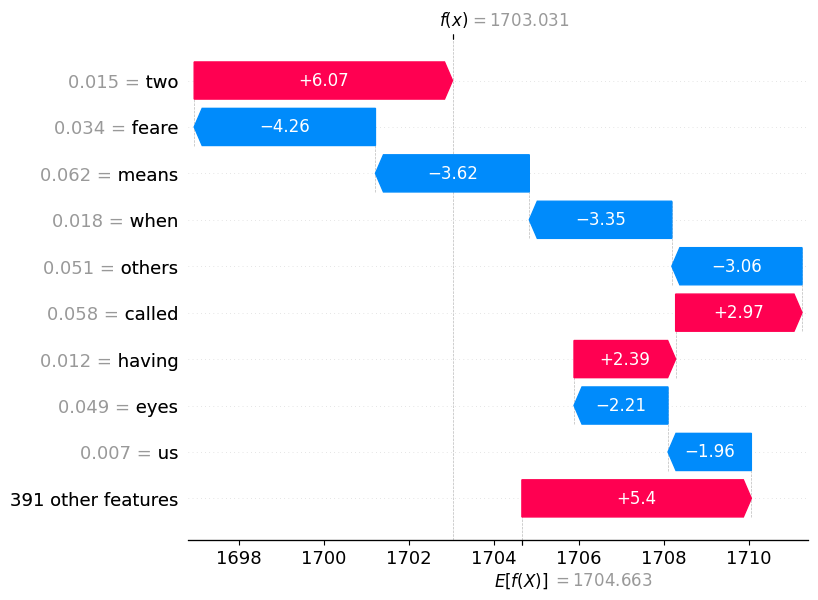

In [74]:
shap.initjs()

shap.plots.waterfall(shap_values[6])

In [40]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=3002)

# Convert to cupy arrays for GPU computation
train_text_features = tfidf_vectorizer.fit_transform(train_data).toarray()
test_text_features = tfidf_vectorizer.transform(test_data).toarray()

# Train the XGBoost model on GPU
#xgb_model = RandomForestRegressor()
xgb_model = XGBRegressor(tree_method='gpu_hist')  # Set tree_method='gpu_hist' for GPU training
xgb_model.fit(train_text_features, train_labels)

# Make predictions on the test set
predictions = xgb_model.predict(test_text_features)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


[16:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Root Mean Squared Error (RMSE): 51.34191280269512


[16:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[16:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



In [41]:
import shap

feature_names = tfidf_vectorizer.get_feature_names_out()
explainer = shap.Explainer(xgb_model.predict,train_text_features[:10],   feature_names=feature_names)
shap_values = explainer(test_text_features[:10], max_evals=4000)
print(shap_values.values.shape)

PermutationExplainer explainer: 11it [00:25,  3.18s/it]                        

(10, 3002)


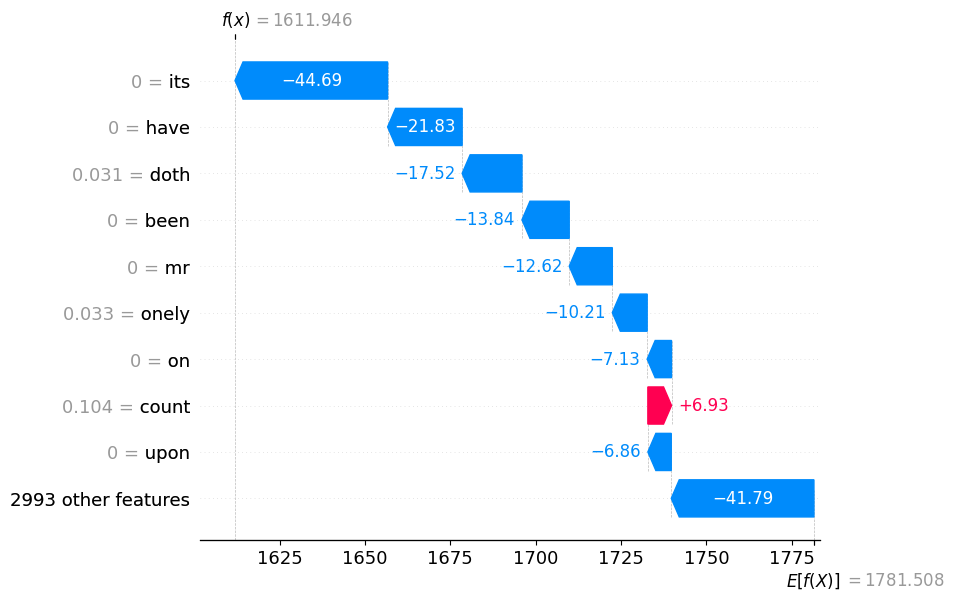

In [42]:
shap.initjs()

shap.plots.waterfall(shap_values[6])

In [44]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(df['text'], df['date'], test_size=0.2, random_state=42)

# Train Word2Vec model on the text data
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)

# Function to average word vectors for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

# Convert text data to Word2Vec features
train_text_features = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.index_to_key, 100) for sentence in train_data]
test_text_features = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.index_to_key, 100) for sentence in test_data]

# Convert lists to numpy arrays
train_text_features = np.array(train_text_features)
test_text_features = np.array(test_text_features)

# Train the XGBoost model on GPU
xgb_model = XGBRegressor(tree_method='gpu_hist')  # Set tree_method='gpu_hist' for GPU training
xgb_model.fit(train_text_features, train_labels)

# Make predictions on the test set
predictions = xgb_model.predict(test_text_features)

# Evaluate the model
rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

[16:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



Root Mean Squared Error (RMSE): 65.9126810351767


[16:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



# DistilBERT 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Sample DataFrame (replace this with your actual data)

# Assuming df is defined

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Scale labels
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.values.reshape(-1, 1)).flatten()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can use any other transformer model available in the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression with one output label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Tokenize the text data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels_scaled, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_scaled, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               train_labels_tensor)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                              torch.tensor(test_encodings['attention_mask']).to(device),
                                              test_labels_tensor)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
model.train()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=38, shuffle=True)

for epoch in range(2):  # Adjust the number of epochs as needed
    print('epoch')
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch
epoch


In [15]:
# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=38, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1)
        predictions.extend(preds.tolist())

# Scale predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

rmse_distilbert = sqrt(mean_squared_error(test_labels, predictions))



In [16]:
print(f"Root Mean Squared Error (RMSE): {rmse_distilbert}")

Root Mean Squared Error (RMSE): 40.39384033489237


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R-squared (R2)
r_squared = r2_score(test_labels, predictions)
print(f"R-squared (R2): {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

R-squared (R2): 0.8908726383143605
Mean Absolute Error (MAE): 30.385927463950484


In [25]:
import numpy as np
import shap

# Define a function to get predictions from the model
def model_predict(input_text):
    model.eval()
    with torch.no_grad():
        encodings = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt').to(device)
        outputs = model(**encodings)
        preds = outputs.logits.squeeze(1)
    return preds.cpu().numpy()

# Wrap the model's forward function so that SHAP can understand it
explainer = shap.Explainer(model_predict, tokenizer)

token_val = [str(i) for i in test_data.values]
# Explain the predictions
print(list(test_data.values))
shap_values = explainer(list(test_data.values)[0], fixed_context=1)

# Plot the SHAP values (if needed)
shap.summary_plot(shap_values, test_data)


['noted of purpose to carie home to his countrie to serue when time should come He founde there other lawes also but of them he made no reckoning Nowe there was one man that aboue the rest was reputedwise and skilfull in matters of state gouernment who was calledThales with whomLycurgusdyd so much by intreatie and for familier friendshippe that he persuaded him to goe with him SPARTA ThisThaleswas called the Poet Harper Thales a poet harper whereupon he had that title and name but in effect he sange all that the best and sufficientest gouernours of the worlde could deuise For all his songes were goodly ditties wherein he dyd exhorte and persuade the people to liue vnder obedience of the law in peace concorde one with the other His words were set out with such tunes countenance accents that were so full of swetenes harmony and pearsing that inwardly it melted mens heartes and drue the hearers of a loue to like the most honest things and to leaue all hatred enmitie sedition and diuision 

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [26]:


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Scale labels
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.values.reshape(-1, 1)).flatten()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can use any other transformer model available in the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression with one output label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Tokenize the text data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels_scaled, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_scaled, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               train_labels_tensor)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                              torch.tensor(test_encodings['attention_mask']).to(device),
                                              test_labels_tensor)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
model.train()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=38, shuffle=True)

losses = []
for epoch in range(1):  # Adjust the number of epochs as needed
    print('epoch')
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=38, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1)
        predictions.extend(preds.tolist())

# Scale predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Loss Drop per Iteration
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Drop per Iteration')
plt.legend()
plt.grid(True)
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


epoch


In [18]:
# use on real life data and verify findings ----------------------------
# additional findings and understanding to make it  a DS model  -------------------------
# Remove workclouds
# words chainging 
# What is the AI reading into- how does it perdict that 

import datasets
import numpy as np
import scipy as sp
import torch
import transformers
import shap 
# load a BERT sentiment analysis model



# define a prediction function
def f(x):
    
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    
    outputs = model(tv)[0].detach().cpu().numpy()
    outputs = scaler.inverse_transform(np.array(outputs).reshape(-1, 1)).flatten()
    #print(outputs)
    #preds = outputs.logits.squeeze(1)
    #scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    #val = sp.special.logit(scores[1:])  # use one vs rest logit units
    return outputs

explainer = shap.Explainer(f, tokenizer)


In [19]:
shap_text = list(test_data.values)[:20]

In [28]:
token_val = [str(i) for i in test_data.values]
# Explain the predictions
print(list(test_data.values))
shap_values = explainer(shap_text, fixed_context=1)

# Plot the SHAP values (if needed)



["untouched many surprising events and turns of fortune which for their infinite variety could not be contained in this little book besides a world of sprightly and cheerful characters both men and women the humor of which it was feared would be lost if it were attempted to reduce the length of them What these Tales shall have been to the YOUNG readers that and much more it is the writers ' wish that the true Plays of Shakespeare may prove to them in older years enrichers of the fancy strengtheners of virtue a withdrawing from all selfish and mercenary thoughts a lesson of all sweet and honorable thoughts d actions to teach courtesy benignity generosity humanity for of examples teaching these virtues his pages are full THE TEMPEST There was a certain island in the sea the only inhabitants of which were an old man whose name was Prospero and his daughter Miranda a very beautiful young lady She came to this island so young that she had no memory of having seen any other human face than h

TypeError: PermutationExplainer.__call__() got an unexpected keyword argument 'fixed_context'

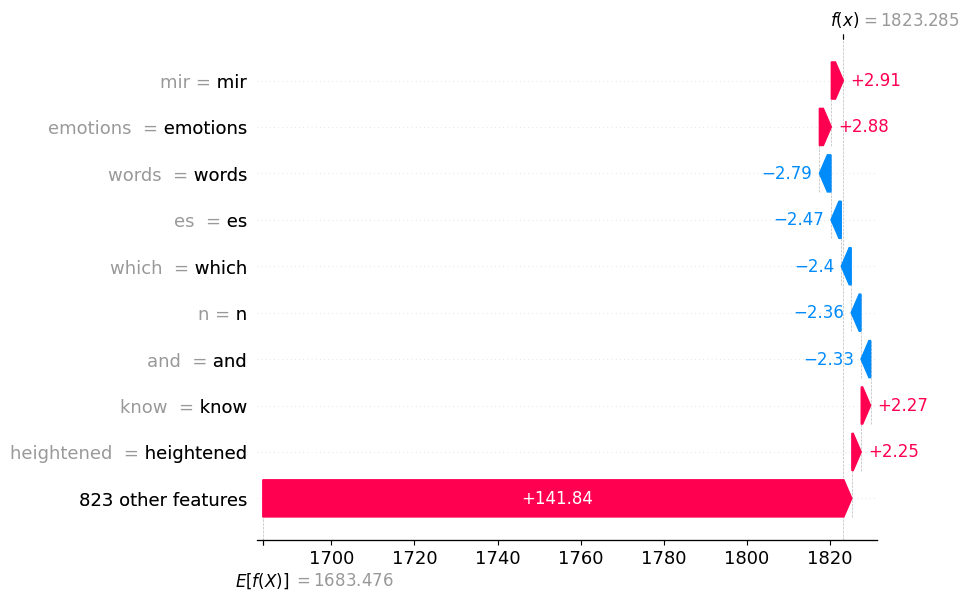

In [21]:
shap.plots.waterfall(shap_values[5])